In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning
from sklearn.tree import DecisionTreeClassifier
from natsort import natsorted
import src.metrics as metrics
from src.binning import *

(CVXPY) Mar 02 09:58:08 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 02 09:58:08 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Loan approvval\default_dataset.csv")

for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f"Column {col} has {df[col].isna().sum()} missing values")
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

#df = df.loc[(df['person_age'] < 100) & (df['person_income'] < 250000)]
df.head()

Column person_emp_length has 895 missing values
Column loan_int_rate has 3116 missing values


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [40]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

class OptimalBinning:
    def __init__(self, min_bins=3, max_bins=10, min_samples_bin=0.05, monotonic_trend=None, p_value_threshold=0.05):
        """
        Initialize the OptimalBinning class.

        Parameters:
        - min_bins: Minimum number of bins.
        - max_bins: Maximum number of bins.
        - min_samples_bin: Minimum percentage of samples per bin.
        - monotonic_trend: Monotonic trend ('ascending', 'descending', 'peak', 'valley').
        - p_value_threshold: Maximum p-value for statistical significance between bins.
        """
        self.min_bins = min_bins
        self.max_bins = max_bins
        self.min_samples_bin = min_samples_bin
        self.monotonic_trend = monotonic_trend
        self.p_value_threshold = p_value_threshold
        self.bins = None
        self.binning_table = None
        self.is_integer = False

    def _pre_binning(self, X, y):
        """
        Pre-binning using a decision tree to create initial split points.
        """
        # Check if X is an integer variable
        self.is_integer = np.all(np.equal(np.mod(X, 1), 0))
        
        tree = DecisionTreeClassifier(max_leaf_nodes=self.max_bins, min_samples_leaf=int(len(X) * self.min_samples_bin), random_state=42, criterion='entropy')
        tree.fit(X.reshape(-1, 1), y)
        thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold != -2])
        
        # Adjust thresholds for integer variables
        if self.is_integer:
            thresholds = np.ceil(thresholds).astype(int)
            # Remove duplicates that might have been created by rounding
            thresholds = np.unique(thresholds)
            
        return thresholds

    def _calculate_woe_iv(self, bin_data, total_events, total_non_events):
        """
        Calculate Weight of Evidence (WoE) and Information Value (IV) for a bin.
        """
        non_events = len(bin_data[bin_data == 0])
        events = len(bin_data[bin_data == 1])
        event_rate = events / (events + non_events) if (events + non_events) > 0 else 0
        
        # Prevent division by zero and log(0)
        if events == 0 or non_events == 0 or total_events == 0 or total_non_events == 0:
            woe = 0
        else:
            woe = np.log((non_events / total_non_events) / (events / total_events))
            
        iv = (non_events / total_non_events - events / total_events) * woe if woe != 0 else 0
        return woe, iv, event_rate

    def _merge_bins(self, X, y, thresholds):
        """
        Merge bins based on constraints and calculate WoE/IV.
        """
        total_events = sum(y)
        total_non_events = len(y) - total_events
        bins = []
        binning_table = []

        for i in range(len(thresholds) + 1):
            if i == 0:
                bin_data = y[X < thresholds[i]]
            elif i == len(thresholds):
                bin_data = y[X >= thresholds[i - 1]]
            else:
                bin_data = y[(X >= thresholds[i - 1]) & (X < thresholds[i])]

            if len(bin_data) > 0:
                woe, iv, event_rate = self._calculate_woe_iv(bin_data, total_events, total_non_events)
                lower_bound = thresholds[i - 1] if i > 0 else -np.inf
                upper_bound = thresholds[i] if i < len(thresholds) else np.inf
                
                # For integer variables, adjust bounds for better interpretability
                if self.is_integer and lower_bound != -np.inf:
                    lower_bound = int(lower_bound)
                if self.is_integer and upper_bound != np.inf:
                    upper_bound = int(upper_bound)
                    
                bins.append((lower_bound, upper_bound))
                binning_table.append({
                    'Bin': f"[{lower_bound}, {upper_bound})",
                    'Count': len(bin_data),
                    'Non-event': len(bin_data[bin_data == 0]),
                    'Event': len(bin_data[bin_data == 1]),
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                })

        return bins, binning_table

    def _enforce_monotonicity(self, binning_table):
        """
        Enforce monotonicity constraints on the binning table by merging violating bins.
        """
        if self.monotonic_trend not in ['ascending', 'descending']:
            return binning_table
            
        merged = True
        while merged and len(binning_table) > 1:
            merged = False
            event_rates = [row['Event rate'] for row in binning_table]
            
            if self.monotonic_trend == 'ascending':
                for i in range(len(event_rates) - 1):
                    if event_rates[i] > event_rates[i + 1]:
                        # Merge bins i and i+1
                        binning_table[i]['Count'] += binning_table[i + 1]['Count']
                        binning_table[i]['Non-event'] += binning_table[i + 1]['Non-event']
                        binning_table[i]['Event'] += binning_table[i + 1]['Event']
                        binning_table[i]['Event rate'] = (binning_table[i]['Event'] / binning_table[i]['Count'] 
                                                          if binning_table[i]['Count'] > 0 else 0)
                        
                        # Update bin range
                        bin1_range = binning_table[i]['Bin'].strip('[]()')
                        bin2_range = binning_table[i + 1]['Bin'].strip('[]()')
                        lower1 = bin1_range.split(',')[0].strip()
                        upper2 = bin2_range.split(',')[1].strip()
                        binning_table[i]['Bin'] = f"[{lower1}, {upper2})"
                        
                        # Remove the merged bin
                        del binning_table[i + 1]
                        merged = True
                        break
                        
            elif self.monotonic_trend == 'descending':
                for i in range(len(event_rates) - 1):
                    if event_rates[i] < event_rates[i + 1]:
                        # Merge bins i and i+1
                        binning_table[i]['Count'] += binning_table[i + 1]['Count']
                        binning_table[i]['Non-event'] += binning_table[i + 1]['Non-event']
                        binning_table[i]['Event'] += binning_table[i + 1]['Event']
                        binning_table[i]['Event rate'] = (binning_table[i]['Event'] / binning_table[i]['Count'] 
                                                          if binning_table[i]['Count'] > 0 else 0)
                        
                        # Update bin range
                        bin1_range = binning_table[i]['Bin'].strip('[]()')
                        bin2_range = binning_table[i + 1]['Bin'].strip('[]()')
                        lower1 = bin1_range.split(',')[0].strip()
                        upper2 = bin2_range.split(',')[1].strip()
                        binning_table[i]['Bin'] = f"[{lower1}, {upper2})"
                        
                        # Remove the merged bin
                        del binning_table[i + 1]
                        merged = True
                        break
        
        # Recalculate WoE and IV for merged bins
        total_events = sum(row['Event'] for row in binning_table)
        total_non_events = sum(row['Non-event'] for row in binning_table)
        
        for row in binning_table:
            events = row['Event']
            non_events = row['Non-event']
            
            if events == 0 or non_events == 0 or total_events == 0 or total_non_events == 0:
                row['WoE'] = 0
                row['IV'] = 0
            else:
                row['WoE'] = np.log((non_events / total_non_events) / (events / total_events))
                row['IV'] = (non_events / total_non_events - events / total_events) * row['WoE']
        
        return binning_table

    def _check_p_value(self, binning_table):
        """
        Check p-value constraints between consecutive bins.
        """
        merged_bins = []
        i = 0
        
        while i < len(binning_table) - 1:
            bin1 = binning_table[i]
            bin2 = binning_table[i + 1]
            
            # Skip bins that were already merged
            if bin1 in merged_bins or bin2 in merged_bins:
                i += 1
                continue
                
            contingency_table = [[bin1['Non-event'], bin1['Event']], [bin2['Non-event'], bin2['Event']]]
            
            # Skip if any expected frequency is too low for chi-square test
            row_sums = [sum(row) for row in contingency_table]
            col_sums = [sum(col) for col in zip(*contingency_table)]
            total = sum(row_sums)
            
            if total == 0:
                i += 1
                continue
                
            expected_too_low = False
            for r in range(2):
                for c in range(2):
                    expected = row_sums[r] * col_sums[c] / total
                    if expected < 5:
                        expected_too_low = True
                        break
            
            if expected_too_low:
                # Merge if expected frequencies are too low
                bin1['Count'] += bin2['Count']
                bin1['Non-event'] += bin2['Non-event']
                bin1['Event'] += bin2['Event']
                bin1['Event rate'] = bin1['Event'] / bin1['Count'] if bin1['Count'] > 0 else 0
                
                # Update bin range
                bin1_range = bin1['Bin'].strip('[]()')
                bin2_range = bin2['Bin'].strip('[]()')
                lower1 = bin1_range.split(',')[0].strip()
                upper2 = bin2_range.split(',')[1].strip()
                bin1['Bin'] = f"[{lower1}, {upper2})"
                
                merged_bins.append(bin2)
                # Don't increment i since we need to check the merged bin against the next one
                continue
            
            try:
                _, p_value, _, _ = chi2_contingency(contingency_table)
                
                if p_value > self.p_value_threshold:
                    # Merge bins with similar distribution
                    bin1['Count'] += bin2['Count']
                    bin1['Non-event'] += bin2['Non-event']
                    bin1['Event'] += bin2['Event']
                    bin1['Event rate'] = bin1['Event'] / bin1['Count'] if bin1['Count'] > 0 else 0
                    
                    # Update bin range
                    bin1_range = bin1['Bin'].strip('[]()')
                    bin2_range = bin2['Bin'].strip('[]()')
                    lower1 = bin1_range.split(',')[0].strip()
                    upper2 = bin2_range.split(',')[1].strip()
                    bin1['Bin'] = f"[{lower1}, {upper2})"
                    
                    merged_bins.append(bin2)
                    # Don't increment i since we need to check the merged bin against the next one
                else:
                    i += 1
            except:
                # If chi2_contingency fails, merge the bins
                bin1['Count'] += bin2['Count']
                bin1['Non-event'] += bin2['Non-event']
                bin1['Event'] += bin2['Event']
                bin1['Event rate'] = bin1['Event'] / bin1['Count'] if bin1['Count'] > 0 else 0
                
                # Update bin range
                bin1_range = bin1['Bin'].strip('[]()')
                bin2_range = bin2['Bin'].strip('[]()')
                lower1 = bin1_range.split(',')[0].strip()
                upper2 = bin2_range.split(',')[1].strip()
                bin1['Bin'] = f"[{lower1}, {upper2})"
                
                merged_bins.append(bin2)
                # Don't increment i
        
        # Remove merged bins
        return [bin for bin in binning_table if bin not in merged_bins]

    def fit(self, X, y):
        """
        Fit the optimal binning model.
        """
        X = np.array(X)
        y = np.array(y)
        
        # Check input
        if len(X) != len(y):
            raise ValueError("X and y must have the same length")
        
        # Ensure y is binary
        unique_y = np.unique(y)
        if len(unique_y) > 2 or not np.all(np.isin(unique_y, [0, 1])):
            raise ValueError("y must be binary (0 or 1)")
        
        # Check if X is an integer type variable
        self.is_integer = np.all(np.equal(np.mod(X, 1), 0))
        
        thresholds = self._pre_binning(X, y)
        
        # Check if we have enough thresholds
        if len(thresholds) < self.min_bins - 1:
            # If not enough split points, create equidistant bins
            min_val, max_val = np.min(X), np.max(X)
            if min_val == max_val:
                raise ValueError("All values in X are identical, cannot create bins")
            
            if self.is_integer:
                # For integer variables, create integer-spaced thresholds
                int_range = int(max_val) - int(min_val)
                if int_range < self.min_bins - 1:
                    # Not enough unique integers for the required bins
                    step = 1
                else:
                    step = max(1, int(int_range / (self.min_bins - 1)))
                thresholds = np.arange(int(min_val) + step, int(max_val), step)
            else:
                # For float variables, create equidistant thresholds
                thresholds = np.linspace(min_val, max_val, self.min_bins + 1)[1:-1]
        
        self.bins, self.binning_table = self._merge_bins(X, y, thresholds)
        
        # Enforce monotonicity constraints
        self.binning_table = self._enforce_monotonicity(self.binning_table)
        
        # Check p-value constraints and merge similar bins
        self.binning_table = self._check_p_value(self.binning_table)
        
        # Update self.bins based on the final binning table
        self.bins = []
        for row in self.binning_table:
            bin_range = row['Bin'].strip('[]()')  # Remove brackets and parentheses
            lower, upper = bin_range.split(',')   # Split into lower and upper bounds
            lower = float(lower.strip()) if lower.strip() != '-inf' else -np.inf
            upper = float(upper.strip()) if upper.strip() != 'inf' else np.inf
            
            # Convert to int for integer variables
            if self.is_integer:
                if lower != -np.inf:
                    lower = int(lower)
                if upper != np.inf:
                    upper = int(upper)
                    
            self.bins.append((lower, upper))

    def transform(self, X):
        """
        Transform the data into binned values.
        """
        if self.bins is None:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'transform'.")
            
        X = np.array(X)
        binned_X = np.zeros_like(X, dtype=object)
        
        for i, (lower, upper) in enumerate(self.bins):
            if i == 0:
                mask = X < upper
            elif i == len(self.bins) - 1:
                mask = X >= lower
            else:
                mask = (X >= lower) & (X < upper)
                
            binned_X[mask] = f"[{lower}, {upper})"
            
        return binned_X

    def get_binning_table(self):
        """
        Return the binning table.
        """
        if self.binning_table is None:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'get_binning_table'.")
            
        return pd.DataFrame(self.binning_table)

    def apply_binning(self, X):
        """
        Apply binning and return WoE values.
        """
        if self.bins is None or self.binning_table is None:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'apply_binning'.")
            
        X = np.array(X)
        binned_X = self.transform(X)
        
        # Create WoE lookup dictionary
        woe_dict = {row['Bin']: row['WoE'] for row in self.binning_table}
        
        # Apply WoE transformation
        woe_X = np.array([woe_dict.get(bin_value, 0) for bin_value in binned_X])
        
        return woe_X

    def plot_binning(self, figsize=(10, 6)):
        """
        Visualize the binning results with a bar plot for event/non-event distribution
        and a line plot for WoE. Round only the x-axis labels (bin ranges) for display.
        """
        if self.binning_table is None:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'plot_binning'.")
        
        # Convert binning table to DataFrame for easier manipulation
        summary = pd.DataFrame(self.binning_table)
        
        # Create rounded bin labels for the x-axis
        rounded_bin_labels = []
        for bin_range in summary['Bin']:
            lower, upper = bin_range.strip('[]()').split(',')
            lower = float(lower.strip())
            upper = float(upper.strip())
            
            # Round the bin boundaries for display
            if lower != -np.inf:
                lower = round(lower, 2)
            if upper != np.inf:
                upper = round(upper, 2)
            
            rounded_bin_labels.append(f"[{lower}, {upper})")
        
        # Plot
        fig, ax1 = plt.subplots(figsize=figsize)
        
        # Bar plot for event/non-event distribution
        counts = pd.DataFrame({
            'Non-Event': summary['Non-event'],
            'Event': summary['Event']
        })
        counts.plot(kind='bar', stacked=True, ax=ax1, colormap="coolwarm", alpha=0.7)
        
        # Use rounded bin labels for the x-axis
        plt.xticks(range(len(summary.index)), rounded_bin_labels, rotation=45, ha='right')
        
        ax1.set_xlabel("Bins (Ranges)")
        ax1.set_ylabel("Number of Observations")
        ax1.set_title(f"Distribution and WoE Analysis\n(Sorted by WoE)")
        
        # Line plot for WoE
        ax2 = ax1.twinx()
        line_plot, = ax2.plot(range(len(summary.index)), summary['WoE'].values, 
                marker='o', color='black', linestyle='-', linewidth=2, 
                label="Weight of Evidence")
        
        ax2.set_ylabel("Weight of Evidence")
        
        # Combine legends
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = [line_plot], ["Weight of Evidence"]
        
        ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper right", fontsize=10, framealpha=0.8)
        
        plt.tight_layout()
        plt.show()

### Explore binning options

#### Decision tree for binning

##### Deicide on maximum number of bins for each variable

In [40]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['person_age']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.5174 ± 0.0163
Max leaf nodes:  3, ROC AUC: 0.5095 ± 0.0151
Max leaf nodes:  4, ROC AUC: 0.5095 ± 0.0152
Max leaf nodes:  5, ROC AUC: 0.5095 ± 0.0152
Max leaf nodes:  6, ROC AUC: 0.5097 ± 0.0150
Max leaf nodes:  7, ROC AUC: 0.5094 ± 0.0138
Max leaf nodes:  8, ROC AUC: 0.5082 ± 0.0135
Max leaf nodes:  9, ROC AUC: 0.5103 ± 0.0132
Max leaf nodes: 10, ROC AUC: 0.5105 ± 0.0128

Best max_leaf_nodes: 2 with ROC AUC: 0.5174


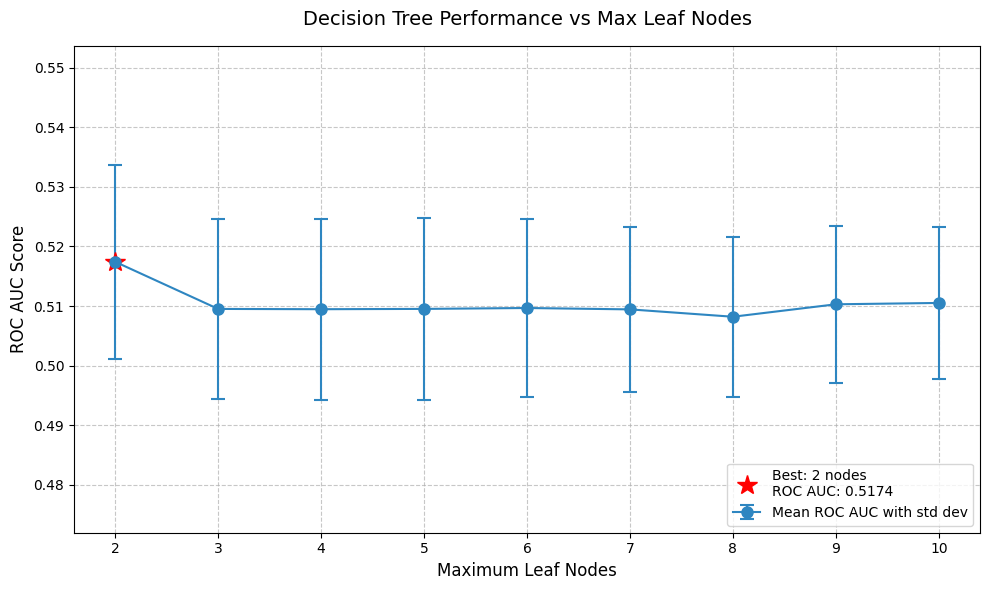

In [41]:
plot_tree_performance(all_results)

##### Binning of variable

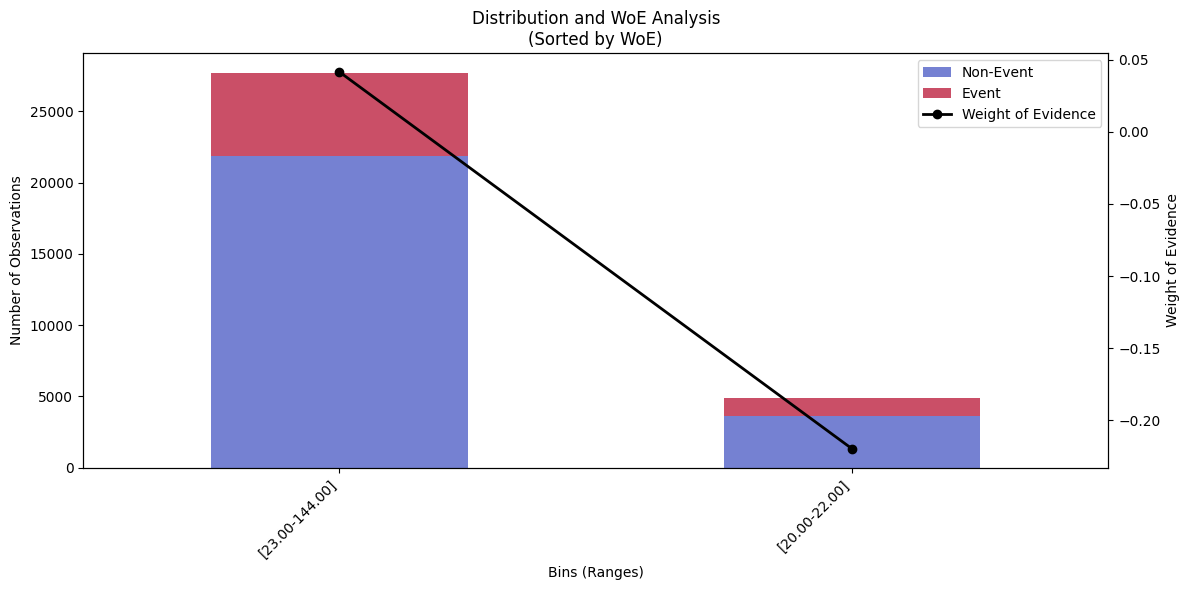

In [42]:
df, bin_stats, bin_labels = create_binned_feature(df, 'person_age', 'loan_status', max_leaf_nodes=2)
df, woe_summary, iv = calculate_woe(df, 'person_age', 'loan_status', plot=True, bin_labels=bin_labels)

In [43]:
woe_summary

,non_event_count,event_count,non_event_rate,event_rate,WoE,IV
person_age_bin_label,,,,,,
[23.00-144.00],21854,5850,0.8579,0.823,0.0415,0.001450
[20.00-22.00],3619,1258,0.1421,0.177,-0.2197,0.007671


In [44]:
woe_summary['IV'].sum()

0.009121295829171754

In [50]:
binner = OptimalBinning(min_bins=2, max_bins=10, min_samples_bin=0.05, monotonic_trend='descending', p_value_threshold=0.05)
binner.fit(df['person_age'], df['loan_status'])
binner.get_binning_table()

,Bin,Count,Non-event,Event,Event rate,WoE,IV
0,"[-inf, 23)",4877,3619,1258,0.257945,-0.219724,0.007671
1,"[23, 29)",16944,13292,3652,0.215534,0.004633,0.000007
2,"[29, inf)",10760,8562,2198,0.204275,0.083388,0.002242


In [51]:
print(binner.get_binning_table()['IV'].sum())

0.00992024033630944


#### Person income

In [92]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['person_income']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.6249 ± 0.0550
Max leaf nodes:  3, ROC AUC: 0.6537 ± 0.0563
Max leaf nodes:  4, ROC AUC: 0.6596 ± 0.0513
Max leaf nodes:  5, ROC AUC: 0.6855 ± 0.0599
Max leaf nodes:  6, ROC AUC: 0.6766 ± 0.0543
Max leaf nodes:  7, ROC AUC: 0.6854 ± 0.0533
Max leaf nodes:  8, ROC AUC: 0.6943 ± 0.0653
Max leaf nodes:  9, ROC AUC: 0.6866 ± 0.0582
Max leaf nodes: 10, ROC AUC: 0.6912 ± 0.0639

Best max_leaf_nodes: 8 with ROC AUC: 0.6943


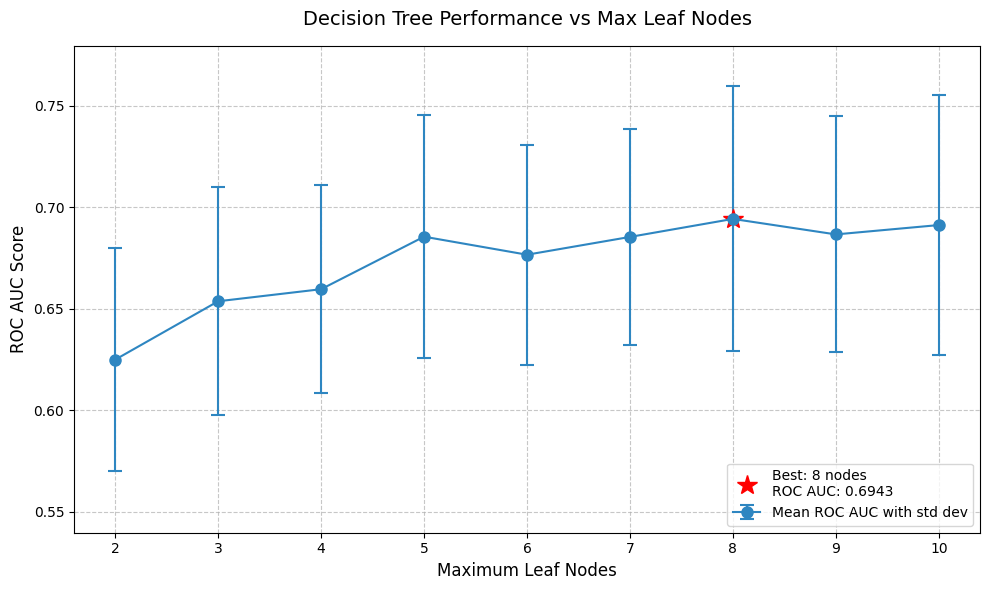

In [93]:
plot_tree_performance(all_results)

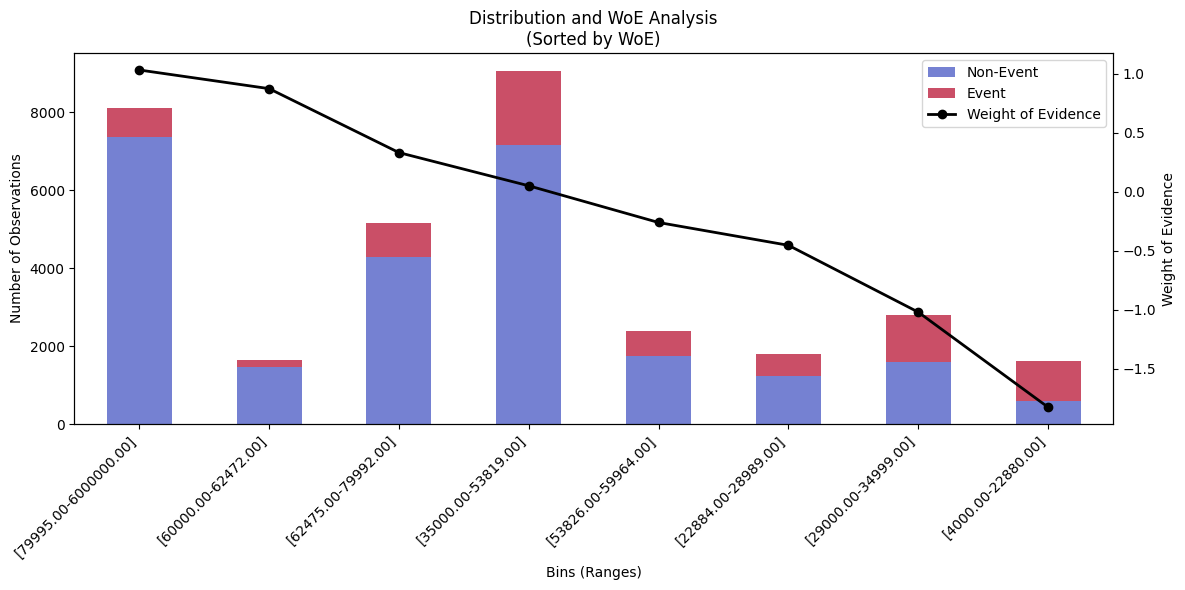

In [158]:
df, bin_stats, bin_labels = create_binned_feature(df, 'person_income', 'loan_status', max_leaf_nodes=8)
df, woe_summary, iv = calculate_woe(df, 'person_income', 'loan_status', plot=True, bin_labels=bin_labels)

In [4]:
binner = OptimalBinning(min_bins=2, max_bins=10, min_samples_bin=0.05, monotonic_trend='descending', p_value_threshold=0.05)
binner.fit(df['person_income'], df['loan_status'])
binner.get_binning_table()['IV'].sum()

0.5665605500670701

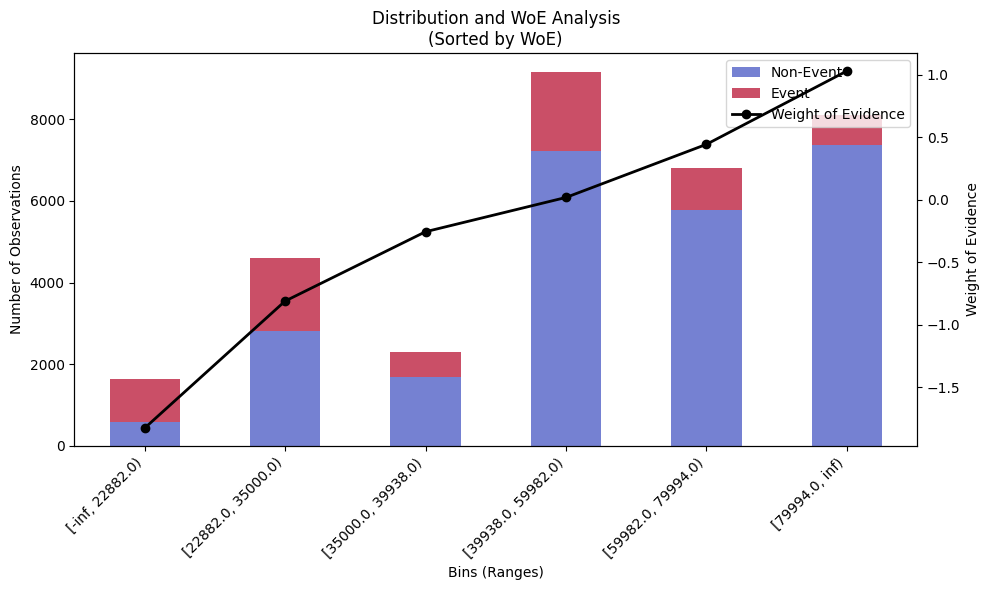

In [5]:
binner.plot_binning()

In [44]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Union, Optional
import warnings

class OptimalBinning2:
    def __init__(
        self, 
        min_bins: int = 3, 
        max_bins: int = 10, 
        min_samples_bin: float = 0.05, 
        monotonic_trend: Optional[str] = None, 
        p_value_threshold: float = 0.05,
        special_values: Optional[List[Union[int, float]]] = None
    ):
        """
        Initialize the OptimalBinning class for discretizing continuous variables.

        Parameters:
        -----------
        min_bins : int, default=3
            Minimum number of bins.
        max_bins : int, default=10
            Maximum number of bins.
        min_samples_bin : float, default=0.05
            Minimum percentage of samples per bin (between 0 and 1).
        monotonic_trend : str, optional
            Monotonic trend constraint ('ascending', 'descending', 'peak', 'valley', None).
            If None, no monotonicity constraint is applied.
        p_value_threshold : float, default=0.05
            Maximum p-value for statistical significance between bins.
            Bins with p-value > threshold will be merged.
        special_values : list, optional
            List of values to be treated separately (e.g., missing values encoded as -999).
        """
        # Validate inputs
        if not isinstance(min_bins, int) or min_bins < 2:
            raise ValueError("min_bins must be an integer >= 2")
        if not isinstance(max_bins, int) or max_bins < min_bins:
            raise ValueError("max_bins must be an integer >= min_bins")
        if not 0 < min_samples_bin < 1:
            raise ValueError("min_samples_bin must be between 0 and 1")
        if monotonic_trend not in [None, 'ascending', 'descending', 'peak', 'valley']:
            raise ValueError("monotonic_trend must be one of: None, 'ascending', 'descending', 'peak', 'valley'")
        if not 0 < p_value_threshold < 1:
            raise ValueError("p_value_threshold must be between 0 and 1")
            
        self.min_bins = min_bins
        self.max_bins = max_bins
        self.min_samples_bin = min_samples_bin
        self.monotonic_trend = monotonic_trend
        self.p_value_threshold = p_value_threshold
        self.special_values = special_values if special_values is not None else []
        
        # Initialize attributes that will be set during fitting
        self.bins = None
        self.binning_table = None
        self.is_integer = False
        self.iv_total = None
        self.special_bins = {}
        self._fitted = False

    def _pre_binning(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Pre-binning using a decision tree to create initial split points.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Feature values.
        y : numpy.ndarray
            Target values (binary).
            
        Returns:
        --------
        numpy.ndarray
            Array of threshold values for binning.
        """
        # Check if X is an integer variable
        self.is_integer = np.all(np.equal(np.mod(X, 1), 0))
        
        # Use entropy criterion for binary classification
        tree = DecisionTreeClassifier(
            max_leaf_nodes=self.max_bins, 
            min_samples_leaf=max(1, int(len(X) * self.min_samples_bin)), 
            random_state=42, 
            criterion='entropy'
        )
        
        try:
            tree.fit(X.reshape(-1, 1), y)
            # Extract thresholds, filtering out sentinel value (-2)
            thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold != -2])
            
            # Adjust thresholds for integer variables
            if self.is_integer:
                thresholds = np.ceil(thresholds).astype(int)
                # Remove duplicates that might have been created by rounding
                thresholds = np.unique(thresholds)
                
            return thresholds
        except Exception as e:
            warnings.warn(f"Decision tree binning failed: {str(e)}. Falling back to equidistant binning.")
            # Fallback to equidistant binning
            min_val, max_val = np.min(X), np.max(X)
            if min_val == max_val:
                return np.array([])
                
            if self.is_integer:
                step = max(1, int((max_val - min_val) / self.min_bins))
                return np.arange(int(min_val) + step, int(max_val), step)
            else:
                return np.linspace(min_val, max_val, self.min_bins + 1)[1:-1]

    def _calculate_woe_iv(
        self, 
        events: int, 
        non_events: int, 
        total_events: int, 
        total_non_events: int
    ) -> Tuple[float, float, float]:
        """
        Calculate Weight of Evidence (WoE) and Information Value (IV) for a bin.
        
        Parameters:
        -----------
        events : int
            Number of events in the bin.
        non_events : int
            Number of non-events in the bin.
        total_events : int
            Total number of events.
        total_non_events : int
            Total number of non-events.
            
        Returns:
        --------
        tuple
            Weight of Evidence, Information Value, and Event Rate.
        """
        # Calculate event rate
        bin_total = events + non_events
        event_rate = events / bin_total if bin_total > 0 else 0
        
        # Small value to prevent division by zero or log(0)
        epsilon = 1e-10
        
        # Calculate WoE with smoothing
        if events == 0 or non_events == 0 or total_events == 0 or total_non_events == 0:
            # Add smoothing for rare events
            events_smooth = events + epsilon
            non_events_smooth = non_events + epsilon
            woe = np.log((non_events_smooth / total_non_events) / (events_smooth / total_events))
        else:
            woe = np.log((non_events / total_non_events) / (events / total_events))
            
        # Calculate IV contribution of this bin
        if woe == 0:
            iv = 0
        else:
            iv = ((non_events / total_non_events) - (events / total_events)) * woe
            
        return woe, iv, event_rate

    def _handle_special_values(
        self, 
        X: np.ndarray, 
        y: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """
        Handle special values specified by the user.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Feature values.
        y : numpy.ndarray
            Target values.
            
        Returns:
        --------
        tuple
            Filtered X, y arrays and special bins dictionary.
        """
        special_bins = {}
        
        if not self.special_values:
            return X, y, special_bins
            
        # Track indices to keep (non-special values)
        keep_indices = np.ones(len(X), dtype=bool)
        total_events = np.sum(y)
        total_non_events = len(y) - total_events
        
        for special_value in self.special_values:
            # Find observations with this special value
            special_mask = np.isclose(X, special_value)
            special_data = y[special_mask]
            
            if len(special_data) > 0:
                # Calculate statistics for this special bin
                events = np.sum(special_data)
                non_events = len(special_data) - events
                woe, iv, event_rate = self._calculate_woe_iv(
                    events, non_events, total_events, total_non_events
                )
                
                # Store information about this special bin
                special_bins[special_value] = {
                    'Bin': f"Special: {special_value}",
                    'Count': len(special_data),
                    'Non-event': non_events,
                    'Event': events,
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                }
                
                # Mark these values to be excluded from regular binning
                keep_indices = keep_indices & ~special_mask
        
        # Return filtered data and special bins
        return X[keep_indices], y[keep_indices], special_bins

    def _merge_bins(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        thresholds: np.ndarray
    ) -> Tuple[List[Tuple], List[Dict]]:
        """
        Create bins based on thresholds and calculate statistics.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Feature values.
        y : numpy.ndarray
            Target values.
        thresholds : numpy.ndarray
            Threshold values for binning.
            
        Returns:
        --------
        tuple
            List of bin ranges and binning table (list of dictionaries).
        """
        total_events = np.sum(y)
        total_non_events = len(y) - total_events
        bins = []
        binning_table = []

        # If no thresholds, create one bin for all data
        if len(thresholds) == 0:
            bin_data = y
            woe, iv, event_rate = self._calculate_woe_iv(
                np.sum(bin_data), len(bin_data) - np.sum(bin_data), 
                total_events, total_non_events
            )
            
            bins.append((-np.inf, np.inf))
            binning_table.append({
                'Bin': f"[-inf, inf)",
                'Count': len(bin_data),
                'Non-event': len(bin_data) - np.sum(bin_data),
                'Event': np.sum(bin_data),
                'Event rate': event_rate,
                'WoE': woe,
                'IV': iv
            })
            return bins, binning_table

        # Create bins based on thresholds
        for i in range(len(thresholds) + 1):
            if i == 0:
                bin_data = y[X < thresholds[i]]
                lower_bound, upper_bound = -np.inf, thresholds[i]
            elif i == len(thresholds):
                bin_data = y[X >= thresholds[i - 1]]
                lower_bound, upper_bound = thresholds[i - 1], np.inf
            else:
                bin_data = y[(X >= thresholds[i - 1]) & (X < thresholds[i])]
                lower_bound, upper_bound = thresholds[i - 1], thresholds[i]

            # Skip empty bins
            if len(bin_data) == 0:
                continue
                
            # Calculate statistics
            woe, iv, event_rate = self._calculate_woe_iv(
                np.sum(bin_data), len(bin_data) - np.sum(bin_data),
                total_events, total_non_events
            )
            
            # Adjust bounds for integer variables
            if self.is_integer:
                if lower_bound != -np.inf:
                    lower_bound = int(lower_bound)
                if upper_bound != np.inf:
                    upper_bound = int(upper_bound)
                    
            bins.append((lower_bound, upper_bound))
            binning_table.append({
                'Bin': f"[{lower_bound}, {upper_bound})",
                'Count': len(bin_data),
                'Non-event': len(bin_data) - np.sum(bin_data),
                'Event': np.sum(bin_data),
                'Event rate': event_rate,
                'WoE': woe,
                'IV': iv
            })

        return bins, binning_table

    def _enforce_monotonicity(self, binning_table: List[Dict]) -> List[Dict]:
        """
        Enforce monotonicity constraints by merging violating bins.
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
            
        Returns:
        --------
        list
            Updated binning table with monotonicity enforced.
        """
        if self.monotonic_trend not in ['ascending', 'descending', 'peak', 'valley']:
            return binning_table
            
        # For peak and valley patterns, we need to find the turning point
        if self.monotonic_trend in ['peak', 'valley']:
            event_rates = [row['Event rate'] for row in binning_table]
            
            if self.monotonic_trend == 'peak':
                # For peak pattern: rates should increase then decrease
                peak_idx = np.argmax(event_rates)
            else:  # valley
                # For valley pattern: rates should decrease then increase
                peak_idx = np.argmin(event_rates)
                
            # Split the binning table at the peak/valley
            left_bins = binning_table[:peak_idx+1]
            right_bins = binning_table[peak_idx+1:]
            
            # Apply ascending trend to left side
            left_bins = self._enforce_simple_monotonicity(left_bins, 'ascending' if self.monotonic_trend == 'peak' else 'descending')
            
            # Apply descending trend to right side
            right_bins = self._enforce_simple_monotonicity(right_bins, 'descending' if self.monotonic_trend == 'peak' else 'ascending')
            
            # Combine the two parts
            return left_bins + right_bins
        else:
            # Simple monotonicity (ascending or descending)
            return self._enforce_simple_monotonicity(binning_table, self.monotonic_trend)
            
    def _enforce_simple_monotonicity(self, binning_table: List[Dict], trend: str) -> List[Dict]:
        """
        Helper method to enforce simple monotonicity (ascending or descending).
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
        trend : str
            Monotonic trend ('ascending' or 'descending').
            
        Returns:
        --------
        list
            Updated binning table with monotonicity enforced.
        """
        if not binning_table:
            return binning_table
            
        # Continue merging bins until monotonicity is achieved
        merged = True
        while merged and len(binning_table) > 1:
            merged = False
            event_rates = [row['Event rate'] for row in binning_table]
            
            if trend == 'ascending':
                for i in range(len(event_rates) - 1):
                    if event_rates[i] > event_rates[i + 1]:
                        # Merge bins i and i+1
                        self._merge_adjacent_bins(binning_table, i)
                        merged = True
                        break
                        
            elif trend == 'descending':
                for i in range(len(event_rates) - 1):
                    if event_rates[i] < event_rates[i + 1]:
                        # Merge bins i and i+1
                        self._merge_adjacent_bins(binning_table, i)
                        merged = True
                        break
        
        # Recalculate WoE and IV for all bins
        self._recalculate_metrics(binning_table)
        
        return binning_table
        
    def _merge_adjacent_bins(self, binning_table: List[Dict], idx: int) -> None:
        """
        Merge two adjacent bins in the binning table.
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
        idx : int
            Index of the first bin to merge.
        """
        # Merge counts and events
        binning_table[idx]['Count'] += binning_table[idx + 1]['Count']
        binning_table[idx]['Non-event'] += binning_table[idx + 1]['Non-event']
        binning_table[idx]['Event'] += binning_table[idx + 1]['Event']
        
        # Recalculate event rate
        if binning_table[idx]['Count'] > 0:
            binning_table[idx]['Event rate'] = binning_table[idx]['Event'] / binning_table[idx]['Count']
        else:
            binning_table[idx]['Event rate'] = 0
        
        # Update bin range
        bin1_range = binning_table[idx]['Bin'].strip('[]()')
        bin2_range = binning_table[idx + 1]['Bin'].strip('[]()')
        
        try:
            # Try to extract lower and upper bounds
            lower1 = bin1_range.split(',')[0].strip()
            upper2 = bin2_range.split(',')[1].strip()
            binning_table[idx]['Bin'] = f"[{lower1}, {upper2})"
        except:
            # Fallback for special cases
            binning_table[idx]['Bin'] = f"Merged: {binning_table[idx]['Bin']} + {binning_table[idx + 1]['Bin']}"
        
        # Remove the merged bin
        del binning_table[idx + 1]

    def _recalculate_metrics(self, binning_table: List[Dict]) -> None:
        """
        Recalculate WoE and IV for all bins in the binning table.
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
        """
        # Calculate totals
        total_events = sum(row['Event'] for row in binning_table)
        total_non_events = sum(row['Non-event'] for row in binning_table)
        
        # Recalculate WoE and IV for each bin
        for row in binning_table:
            events = row['Event']
            non_events = row['Non-event']
            
            woe, iv, _ = self._calculate_woe_iv(
                events, non_events, total_events, total_non_events
            )
            
            row['WoE'] = woe
            row['IV'] = iv

    def _check_p_value(self, binning_table: List[Dict]) -> List[Dict]:
        """
        Check p-value constraints and merge bins with similar distributions.
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
            
        Returns:
        --------
        list
            Updated binning table after merging similar bins.
        """
        if len(binning_table) <= 1:
            return binning_table
            
        # Track which bins are already merged
        merged_bins = set()
        i = 0
        
        while i < len(binning_table) - 1:
            bin1 = binning_table[i]
            bin2 = binning_table[i + 1]
            
            # Skip bins that were already merged
            if i in merged_bins or i + 1 in merged_bins:
                i += 1
                continue
                
            # Create contingency table for chi-square test
            contingency_table = [
                [bin1['Non-event'], bin1['Event']], 
                [bin2['Non-event'], bin2['Event']]
            ]
            
            # Check if any expected frequency might be too low
            row_sums = [sum(row) for row in contingency_table]
            col_sums = [sum(col) for col in zip(*contingency_table)]
            total = sum(row_sums)
            
            if total == 0:
                i += 1
                continue
                
            # Check expected frequencies
            expected_too_low = False
            for r in range(2):
                for c in range(2):
                    expected = row_sums[r] * col_sums[c] / total
                    if expected < 5:
                        expected_too_low = True
                        break
            
            if expected_too_low:
                # Merge if expected frequencies are too low
                self._merge_adjacent_bins(binning_table, i)
                merged_bins.add(i + 1)
                # Don't increment i to check the merged bin against the next one
                continue
            
            # Perform chi-square test
            try:
                _, p_value, _, _ = chi2_contingency(contingency_table)
                
                if p_value > self.p_value_threshold:
                    # Merge bins with similar distribution
                    self._merge_adjacent_bins(binning_table, i)
                    merged_bins.add(i + 1)
                    # Don't increment i to check the merged bin against the next one
                else:
                    i += 1
            except Exception:
                # If chi2_contingency fails, merge the bins
                self._merge_adjacent_bins(binning_table, i)
                merged_bins.add(i + 1)
                # Don't increment i
        
        # Recalculate metrics after all merges
        self._recalculate_metrics(binning_table)
        
        return binning_table

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'OptimalBinning':
        """
        Fit the optimal binning model.
        
        Parameters:
        -----------
        X : array-like
            Feature values to bin.
        y : array-like
            Binary target values (0 or 1).
            
        Returns:
        --------
        self : OptimalBinning
            Fitted instance of the class.
        """
        # Convert inputs to numpy arrays
        X = np.asarray(X).flatten()
        y = np.asarray(y).flatten()
        
        # Check input
        if len(X) != len(y):
            raise ValueError("X and y must have the same length")
        
        # Check for NaN values
        if np.isnan(X).any():
            raise ValueError("X contains NaN values. Please handle missing values before fitting.")
        if np.isnan(y).any():
            raise ValueError("y contains NaN values. Please handle missing values before fitting.")
        
        # Ensure y is binary
        unique_y = np.unique(y)
        if len(unique_y) > 2 or not np.all(np.isin(unique_y, [0, 1])):
            raise ValueError("y must be binary (0 or 1)")
        
        # Handle special values if specified
        filtered_X, filtered_y, self.special_bins = self._handle_special_values(X, y)
        
        # If all values are special, create a fallback bin
        if len(filtered_X) == 0:
            self.bins = [(-np.inf, np.inf)]
            self.binning_table = [{
                'Bin': "[-inf, inf)",
                'Count': 0,
                'Non-event': 0,
                'Event': 0,
                'Event rate': 0,
                'WoE': 0,
                'IV': 0
            }]
            self._fitted = True
            self.iv_total = 0
            return self
            
        # Check if X is an integer type variable
        self.is_integer = np.all(np.equal(np.mod(filtered_X, 1), 0))
        
        # Get initial thresholds
        thresholds = self._pre_binning(filtered_X, filtered_y)
        
        # Create initial bins
        self.bins, self.binning_table = self._merge_bins(filtered_X, filtered_y, thresholds)
        
        # Apply constraints in sequence
        
        # 1. Enforce monotonicity constraints
        if self.monotonic_trend:
            self.binning_table = self._enforce_monotonicity(self.binning_table)
        
        # 2. Check p-value constraints and merge similar bins
        self.binning_table = self._check_p_value(self.binning_table)
        
        # 3. Add special bins
        for special_info in self.special_bins.values():
            self.binning_table.append(special_info)
        
        # Ensure we have at least min_bins if possible
        if len(self.binning_table) < self.min_bins and len(np.unique(X)) >= self.min_bins:
            warnings.warn(
                f"Resulting number of bins ({len(self.binning_table)}) "
                f"is less than min_bins ({self.min_bins}). "
                "Consider adjusting parameters."
            )
        
        # Update bins based on final binning table
        self.bins = []
        for row in self.binning_table:
            # Skip special bins
            if "Special:" in row['Bin'] or "Merged:" in row['Bin']:
                continue
                
            bin_range = row['Bin'].strip('[]()')
            lower, upper = bin_range.split(',')
            lower = float(lower.strip()) if lower.strip() != '-inf' else -np.inf
            upper = float(upper.strip()) if upper.strip() != 'inf' else np.inf
            
            # Convert to int for integer variables
            if self.is_integer:
                if lower != -np.inf:
                    lower = int(lower)
                if upper != np.inf:
                    upper = int(upper)
                    
            self.bins.append((lower, upper))
        
        # Calculate total IV
        self.iv_total = sum(row['IV'] for row in self.binning_table)
        
        self._fitted = True
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform the data into binned values (bin labels).
        
        Parameters:
        -----------
        X : array-like
            Feature values to bin.
            
        Returns:
        --------
        numpy.ndarray
            Binned values as strings (bin labels).
        """
        if not self._fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'transform'.")
            
        X = np.asarray(X).flatten()
        binned_X = np.full_like(X, fill_value="", dtype=object)
        
        # Handle special values first
        for special_value in self.special_values:
            special_mask = np.isclose(X, special_value)
            if special_value in self.special_bins:
                binned_X[special_mask] = self.special_bins[special_value]['Bin']
        
        # Handle regular bins
        for lower, upper in self.bins:
            if lower == -np.inf:
                mask = (X < upper) & (binned_X == "")
            elif upper == np.inf:
                mask = (X >= lower) & (binned_X == "")
            else:
                mask = (X >= lower) & (X < upper) & (binned_X == "")
                
            binned_X[mask] = f"[{lower}, {upper})"
        
        # Handle any values that didn't fit into bins
        remaining_mask = binned_X == ""
        if np.any(remaining_mask):
            warnings.warn(f"{np.sum(remaining_mask)} values did not fit into any bin and will be labeled as 'Other'.")
            binned_X[remaining_mask] = "Other"
            
        return binned_X

    def apply_binning(self, X: np.ndarray) -> np.ndarray:
        """
        Apply binning and return WoE values.
        
        Parameters:
        -----------
        X : array-like
            Feature values to bin.
            
        Returns:
        --------
        numpy.ndarray
            WoE-transformed values.
        """
        if not self._fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'apply_binning'.")
            
        X = np.asarray(X).flatten()
        binned_X = self.transform(X)
        
        # Create WoE lookup dictionary
        woe_dict = {row['Bin']: row['WoE'] for row in self.binning_table}
        
        # Apply WoE transformation
        woe_X = np.array([woe_dict.get(bin_value, 0) for bin_value in binned_X])
        
        return woe_X

    def get_binning_table(self) -> pd.DataFrame:
        """
        Return the binning table as a pandas DataFrame.
        
        Returns:
        --------
        pandas.DataFrame
            Binning table with bin statistics.
        """
        if not self._fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'get_binning_table'.")
            
        # Convert to DataFrame and add total IV
        df = pd.DataFrame(self.binning_table)
        
        # Add percentage of total IV
        if self.iv_total > 0:
            df['IV_percentage'] = (df['IV'] / self.iv_total * 100).round(2)
        else:
            df['IV_percentage'] = 0.0
            
        return df

    def plot_binning(self, figsize=(10, 6)):
        """
        Visualize the binning results with a bar plot for event/non-event distribution
        and a line plot for WoE. Round only the x-axis labels (bin ranges) for display.
        """
        if not self._fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'plot_binning'.")
        
        if not self.binning_table:
            warnings.warn("Empty binning table, nothing to plot.")
            return
        
        # Convert binning table to DataFrame for easier manipulation
        summary = pd.DataFrame(self.binning_table)
        
        # Create rounded bin labels for the x-axis
        rounded_bin_labels = []
        for bin_range in summary['Bin']:
            # Handle special bins
            if "Special:" in bin_range or "Merged:" in bin_range or "Other" in bin_range:
                rounded_bin_labels.append(bin_range)
                continue
            
            # Regular bins
            try:
                lower, upper = bin_range.strip('[]()').split(',')
                lower = lower.strip()
                upper = upper.strip()
                
                # Format lower bound
                if lower == '-inf':
                    lower_fmt = "-∞"
                else:
                    lower_val = float(lower)
                    if self.is_integer and lower_val != -np.inf:
                        lower_fmt = str(int(lower_val))
                    else:
                        lower_fmt = format(float(lower), '.2g')
                
                # Format upper bound
                if upper == 'inf':
                    upper_fmt = "∞"
                else:
                    upper_val = float(upper)
                    if self.is_integer and upper_val != np.inf:
                        upper_fmt = str(int(upper_val))
                    else:
                        upper_fmt = format(float(upper), '.2g')
                
                rounded_bin_labels.append(f"[{lower_fmt}, {upper_fmt})")
            except:
                rounded_bin_labels.append(bin_range)
        
        # Plot
        fig, ax1 = plt.subplots(figsize=figsize)
        
        # Bar plot for event/non-event distribution
        counts = pd.DataFrame({
            'Non-Event': summary['Non-event'],
            'Event': summary['Event']
        })
        counts.plot(kind='bar', stacked=True, ax=ax1, colormap="coolwarm", alpha=0.7)
        
        # Use rounded bin labels for the x-axis
        plt.xticks(range(len(summary.index)), rounded_bin_labels, rotation=45, ha='right')
        
        ax1.set_xlabel("Bins (Ranges)")
        ax1.set_ylabel("Number of Observations")
        ax1.set_title(f"Distribution and WoE Analysis\n(Sorted by WoE)")
        
        # Line plot for WoE
        ax2 = ax1.twinx()
        line_plot, = ax2.plot(range(len(summary.index)), summary['WoE'].values, 
                marker='o', color='black', linestyle='-', linewidth=2, 
                label="Weight of Evidence")
        
        ax2.set_ylabel("Weight of Evidence")
        
        # Combine legends
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = [line_plot], ["Weight of Evidence"]
        
        ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper right", fontsize=10, framealpha=0.8)
        
        plt.tight_layout()
        plt.show()

    def __repr__(self) -> str:
        """
        Return a string representation of the fitted binning model.
        
        Returns:
        --------
        str
            Summary of the fitted model.
        """
        if not self._fitted:
            return "OptimalBinning (not fitted)"
            
        summary = f"OptimalBinning (fitted)\n"
        summary += f"  Number of bins: {len(self.binning_table)}\n"
        summary += f"  Total IV: {self.iv_total:.4f}\n"
        if self.monotonic_trend:
            summary += f"  Monotonic Trend: {self.monotonic_trend}\n"
        if self.special_values:
            summary += f"  Special Values: {self.special_values}\n"
        return summary

In [26]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Union, Optional
import warnings

class OptimalBinning3:
    def __init__(
        self, 
        min_bins: int = 3, 
        max_bins: int = 10, 
        min_samples_bin: float = 0.05, 
        monotonic_trend: Optional[str] = None, 
        p_value_threshold: float = 0.05,
        special_values: Optional[List[Union[int, float, str]]] = None,
        variable_type: str = "continuous"
    ):
        """
        Initialize the OptimalBinning class for discretizing continuous or categorical variables.

        Parameters:
        -----------
        min_bins : int, default=3
            Minimum number of bins.
        max_bins : int, default=10
            Maximum number of bins.
        min_samples_bin : float, default=0.05
            Minimum percentage of samples per bin (between 0 and 1).
        monotonic_trend : str, optional
            Monotonic trend constraint ('ascending', 'descending', 'peak', 'valley', None).
            If None, no monotonicity constraint is applied.
        p_value_threshold : float, default=0.05
            Maximum p-value for statistical significance between bins.
            Bins with p-value > threshold will be merged.
        special_values : list, optional
            List of values to be treated separately (e.g., missing values encoded as -999).
        variable_type : str, default="continuous"
            Type of variable to bin. Must be "continuous" or "categorical".
        """
        # Validate inputs
        if not isinstance(min_bins, int) or min_bins < 2:
            raise ValueError("min_bins must be an integer >= 2")
        if not isinstance(max_bins, int) or max_bins < min_bins:
            raise ValueError("max_bins must be an integer >= min_bins")
        if not 0 < min_samples_bin < 1:
            raise ValueError("min_samples_bin must be between 0 and 1")
        if monotonic_trend not in [None, 'ascending', 'descending', 'peak', 'valley']:
            raise ValueError("monotonic_trend must be one of: None, 'ascending', 'descending', 'peak', 'valley'")
        if not 0 < p_value_threshold < 1:
            raise ValueError("p_value_threshold must be between 0 and 1")
        if variable_type not in ["continuous", "categorical"]:
            raise ValueError("variable_type must be 'continuous' or 'categorical'")
            
        self.min_bins = min_bins
        self.max_bins = max_bins
        self.min_samples_bin = min_samples_bin
        self.monotonic_trend = monotonic_trend
        self.p_value_threshold = p_value_threshold
        self.special_values = special_values if special_values is not None else []
        self.variable_type = variable_type
        
        # Initialize attributes that will be set during fitting
        self.bins = None
        self.binning_table = None
        self.is_integer = False
        self.iv_total = None
        self.special_bins = {}
        self._fitted = False

    def _pre_binning(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Pre-binning to create initial split points or groups.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Feature values.
        y : numpy.ndarray
            Target values (binary).
            
        Returns:
        --------
        numpy.ndarray
            Array of threshold values for continuous variables or grouped categories for categorical variables.
        """
        if self.variable_type == "continuous":
            # Check if X is an integer variable
            self.is_integer = np.all(np.equal(np.mod(X, 1), 0))
            
            # Use entropy criterion for binary classification
            tree = DecisionTreeClassifier(
                max_leaf_nodes=self.max_bins, 
                min_samples_leaf=max(1, int(len(X) * self.min_samples_bin)), 
                random_state=42, 
                criterion='entropy'
            )
            
            try:
                tree.fit(X.reshape(-1, 1), y)
                # Extract thresholds, filtering out sentinel value (-2)
                thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold != -2])
                
                # Adjust thresholds for integer variables
                if self.is_integer:
                    thresholds = np.ceil(thresholds).astype(int)
                    # Remove duplicates that might have been created by rounding
                    thresholds = np.unique(thresholds)
                    
                return thresholds
            except Exception as e:
                warnings.warn(f"Decision tree binning failed: {str(e)}. Falling back to equidistant binning.")
                # Fallback to equidistant binning
                min_val, max_val = np.min(X), np.max(X)
                if min_val == max_val:
                    return np.array([])
                    
                if self.is_integer:
                    step = max(1, int((max_val - min_val) / self.min_bins))
                    return np.arange(int(min_val) + step, int(max_val), step)
                else:
                    return np.linspace(min_val, max_val, self.min_bins + 1)[1:-1]
        else:
            unique_categories = np.unique(X)
    
            # Calculate event rate and count for each category
            category_stats = []
            for cat in unique_categories:
                mask = X == cat
                count = np.sum(mask)
                events = np.sum(y[mask])
                event_rate = events / count if count > 0 else 0
                
                category_stats.append({
                    'category': cat,
                    'count': count,
                    'events': events,
                    'event_rate': event_rate
                })
            
            # Sort categories by event rate
            category_stats.sort(key=lambda x: x['event_rate'])
            
            # Use CHAID-like approach to find optimal split points
            # This algorithm would recursively find split points maximizing chi-square
            optimal_groups = self._chaid_split(category_stats)
            
            return optimal_groups

    def _chaid_split(self, category_stats, max_depth=3, min_p_value=0.05):
        """
        Implement a CHAID-like algorithm for finding optimal category groupings.
        
        Parameters:
        -----------
        category_stats : list
            List of dictionaries with category statistics.
        max_depth : int
            Maximum depth of the recursive splitting.
        min_p_value : float
            Minimum p-value for a significant split.
            
        Returns:
        --------
        list
            List of optimal category groupings.
        """
        # Base case: if only one category or max depth reached
        if len(category_stats) <= 1 or max_depth == 0:
            return [tuple(item['category'] for item in category_stats)]
        
        # Find the best split point
        best_p_value = 1.0
        best_split_idx = None
        
        for i in range(1, len(category_stats)):
            left = category_stats[:i]
            right = category_stats[i:]
            
            # Create contingency table for chi-square test
            left_events = sum(item['events'] for item in left)
            left_non_events = sum(item['count'] - item['events'] for item in left)
            
            right_events = sum(item['events'] for item in right)
            right_non_events = sum(item['count'] - item['events'] for item in right)
            
            contingency = np.array([
                [left_non_events, left_events],
                [right_non_events, right_events]
            ])
            
            # Calculate chi-square statistic and p-value
            try:
                _, p_value, _, _ = chi2_contingency(contingency)
                
                if p_value < best_p_value:
                    best_p_value = p_value
                    best_split_idx = i
            except:
                continue
        
        # If no significant split found, return all categories as one group
        if best_split_idx is None or best_p_value > min_p_value:
            return [tuple(item['category'] for item in category_stats)]
        
        # Recursively split left and right groups
        left_groups = self._chaid_split(category_stats[:best_split_idx], max_depth - 1, min_p_value)
        right_groups = self._chaid_split(category_stats[best_split_idx:], max_depth - 1, min_p_value)
        
        return left_groups + right_groups

    def _calculate_woe_iv(
        self, 
        events: int, 
        non_events: int, 
        total_events: int, 
        total_non_events: int
    ) -> Tuple[float, float, float]:
        """
        Calculate Weight of Evidence (WoE) and Information Value (IV) for a bin.
        """
        # Calculate event rate
        bin_total = events + non_events
        event_rate = events / bin_total if bin_total > 0 else 0
        
        # Small value to prevent division by zero or log(0)
        epsilon = 1e-10
        
        # Calculate WoE with smoothing
        if events == 0 or non_events == 0 or total_events == 0 or total_non_events == 0:
            # Add smoothing for rare events
            events_smooth = events + epsilon
            non_events_smooth = non_events + epsilon
            woe = np.log((non_events_smooth / total_non_events) / (events_smooth / total_events))
        else:
            woe = np.log((non_events / total_non_events) / (events / total_events))
            
        # Calculate IV contribution of this bin
        if woe == 0:
            iv = 0
        else:
            iv = ((non_events / total_non_events) - (events / total_events)) * woe
            
        return woe, iv, event_rate

    def _handle_special_values(
        self, 
        X: np.ndarray, 
        y: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """
        Handle special values specified by the user.
        """
        special_bins = {}
        
        if not self.special_values:
            return X, y, special_bins
            
        # Track indices to keep (non-special values)
        keep_indices = np.ones(len(X), dtype=bool)
        total_events = np.sum(y)
        total_non_events = len(y) - total_events
        
        for special_value in self.special_values:
            # Find observations with this special value
            if self.variable_type == "continuous":
                special_mask = np.isclose(X, special_value)
            else:
                special_mask = (X == special_value)
            
            special_data = y[special_mask]
            
            if len(special_data) > 0:
                # Calculate statistics for this special bin
                events = np.sum(special_data)
                non_events = len(special_data) - events
                woe, iv, event_rate = self._calculate_woe_iv(
                    events, non_events, total_events, total_non_events
                )
                
                # Store information about this special bin
                special_bins[special_value] = {
                    'Bin': f"Special: {special_value}",
                    'Count': len(special_data),
                    'Non-event': non_events,
                    'Event': events,
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                }
                
                # Mark these values to be excluded from regular binning
                keep_indices = keep_indices & ~special_mask
        
        # Return filtered data and special bins
        return X[keep_indices], y[keep_indices], special_bins

    def _merge_bins(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        thresholds: np.ndarray
    ) -> Tuple[List[Tuple], List[Dict]]:
        """
        Create bins based on thresholds or grouped categories.
        """
        total_events = np.sum(y)
        total_non_events = len(y) - total_events
        bins = []
        binning_table = []

        if self.variable_type == "continuous":
            # Create bins based on thresholds for continuous variables
            if len(thresholds) == 0:
                bin_data = y
                woe, iv, event_rate = self._calculate_woe_iv(
                    np.sum(bin_data), len(bin_data) - np.sum(bin_data), 
                    total_events, total_non_events
                )
                
                bins.append((-np.inf, np.inf))
                binning_table.append({
                    'Bin': f"[-inf, inf)",
                    'Count': len(bin_data),
                    'Non-event': len(bin_data) - np.sum(bin_data),
                    'Event': np.sum(bin_data),
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                })
                return bins, binning_table

            for i in range(len(thresholds) + 1):
                if i == 0:
                    bin_data = y[X < thresholds[i]]
                    lower_bound, upper_bound = -np.inf, thresholds[i]
                elif i == len(thresholds):
                    bin_data = y[X >= thresholds[i - 1]]
                    lower_bound, upper_bound = thresholds[i - 1], np.inf
                else:
                    bin_data = y[(X >= thresholds[i - 1]) & (X < thresholds[i])]
                    lower_bound, upper_bound = thresholds[i - 1], thresholds[i]

                # Skip empty bins
                if len(bin_data) == 0:
                    continue
                    
                # Calculate statistics
                woe, iv, event_rate = self._calculate_woe_iv(
                    np.sum(bin_data), len(bin_data) - np.sum(bin_data),
                    total_events, total_non_events
                )
                
                # Adjust bounds for integer variables
                if self.is_integer:
                    if lower_bound != -np.inf:
                        lower_bound = int(lower_bound)
                    if upper_bound != np.inf:
                        upper_bound = int(upper_bound)
                        
                bins.append((lower_bound, upper_bound))
                binning_table.append({
                    'Bin': f"[{lower_bound}, {upper_bound})",
                    'Count': len(bin_data),
                    'Non-event': len(bin_data) - np.sum(bin_data),
                    'Event': np.sum(bin_data),
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                })
        else:
            # Create bins based on grouped categories for categorical variables
            for group in thresholds:
                bin_data = y[np.isin(X, group)]
                if len(bin_data) == 0:
                    continue
                    
                woe, iv, event_rate = self._calculate_woe_iv(
                    np.sum(bin_data), len(bin_data) - np.sum(bin_data),
                    total_events, total_non_events
                )
                
                bins.append(tuple(group))
                binning_table.append({
                    'Bin': f"{group}",
                    'Count': len(bin_data),
                    'Non-event': len(bin_data) - np.sum(bin_data),
                    'Event': np.sum(bin_data),
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                })

        return bins, binning_table

    def _merge_bins(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        thresholds: np.ndarray
    ) -> Tuple[List[Tuple], List[Dict]]:
        """
        Create bins based on thresholds or grouped categories.
        """
        total_events = np.sum(y)
        total_non_events = len(y) - total_events
        bins = []
        binning_table = []

        if self.variable_type == "continuous":
            # Create bins based on thresholds for continuous variables
            if len(thresholds) == 0:
                bin_data = y
                woe, iv, event_rate = self._calculate_woe_iv(
                    np.sum(bin_data), len(bin_data) - np.sum(bin_data), 
                    total_events, total_non_events
                )
                
                bins.append((-np.inf, np.inf))
                binning_table.append({
                    'Bin': f"[-inf, inf)",
                    'Count': len(bin_data),
                    'Non-event': len(bin_data) - np.sum(bin_data),
                    'Event': np.sum(bin_data),
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                })
                return bins, binning_table

            for i in range(len(thresholds) + 1):
                if i == 0:
                    bin_data = y[X < thresholds[i]]
                    lower_bound, upper_bound = -np.inf, thresholds[i]
                elif i == len(thresholds):
                    bin_data = y[X >= thresholds[i - 1]]
                    lower_bound, upper_bound = thresholds[i - 1], np.inf
                else:
                    bin_data = y[(X >= thresholds[i - 1]) & (X < thresholds[i])]
                    lower_bound, upper_bound = thresholds[i - 1], thresholds[i]

                # Skip empty bins
                if len(bin_data) == 0:
                    continue
                    
                # Calculate statistics
                woe, iv, event_rate = self._calculate_woe_iv(
                    np.sum(bin_data), len(bin_data) - np.sum(bin_data),
                    total_events, total_non_events
                )
                
                # Adjust bounds for integer variables
                if self.is_integer:
                    if lower_bound != -np.inf:
                        lower_bound = int(lower_bound)
                    if upper_bound != np.inf:
                        upper_bound = int(upper_bound)
                        
                bins.append((lower_bound, upper_bound))
                binning_table.append({
                    'Bin': f"[{lower_bound}, {upper_bound})",
                    'Count': len(bin_data),
                    'Non-event': len(bin_data) - np.sum(bin_data),
                    'Event': np.sum(bin_data),
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                })
        else:
            # Create bins based on grouped categories for categorical variables
            for group in thresholds:
                bin_data = y[np.isin(X, group)]
                if len(bin_data) == 0:
                    continue
                    
                woe, iv, event_rate = self._calculate_woe_iv(
                    np.sum(bin_data), len(bin_data) - np.sum(bin_data),
                    total_events, total_non_events
                )
                
                bins.append(tuple(group))
                binning_table.append({
                    'Bin': f"{group}",
                    'Count': len(bin_data),
                    'Non-event': len(bin_data) - np.sum(bin_data),
                    'Event': np.sum(bin_data),
                    'Event rate': event_rate,
                    'WoE': woe,
                    'IV': iv
                })

        return bins, binning_table

    def _enforce_monotonicity(self, binning_table: List[Dict]) -> List[Dict]:
        """
        Enforce monotonicity constraints by merging violating bins.
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
            
        Returns:
        --------
        list
            Updated binning table with monotonicity enforced.
        """
        if self.monotonic_trend not in ['ascending', 'descending', 'peak', 'valley']:
            return binning_table
            
        # For peak and valley patterns, we need to find the turning point
        if self.monotonic_trend in ['peak', 'valley']:
            event_rates = [row['Event rate'] for row in binning_table]
            
            if self.monotonic_trend == 'peak':
                # For peak pattern: rates should increase then decrease
                peak_idx = np.argmax(event_rates)
            else:  # valley
                # For valley pattern: rates should decrease then increase
                peak_idx = np.argmin(event_rates)
                
            # Split the binning table at the peak/valley
            left_bins = binning_table[:peak_idx+1]
            right_bins = binning_table[peak_idx+1:]
            
            # Apply ascending trend to left side
            left_bins = self._enforce_simple_monotonicity(left_bins, 'ascending' if self.monotonic_trend == 'peak' else 'descending')
            
            # Apply descending trend to right side
            right_bins = self._enforce_simple_monotonicity(right_bins, 'descending' if self.monotonic_trend == 'peak' else 'ascending')
            
            # Combine the two parts
            return left_bins + right_bins
        else:
            # Simple monotonicity (ascending or descending)
            return self._enforce_simple_monotonicity(binning_table, self.monotonic_trend)
            
    def _enforce_simple_monotonicity(self, binning_table: List[Dict], trend: str) -> List[Dict]:
        """
        Helper method to enforce simple monotonicity (ascending or descending).
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
        trend : str
            Monotonic trend ('ascending' or 'descending').
            
        Returns:
        --------
        list
            Updated binning table with monotonicity enforced.
        """
        if not binning_table:
            return binning_table
            
        # Continue merging bins until monotonicity is achieved
        merged = True
        while merged and len(binning_table) > 1:
            merged = False
            event_rates = [row['Event rate'] for row in binning_table]
            
            if trend == 'ascending':
                for i in range(len(event_rates) - 1):
                    if event_rates[i] > event_rates[i + 1]:
                        # Merge bins i and i+1
                        self._merge_adjacent_bins(binning_table, i)
                        merged = True
                        break
                        
            elif trend == 'descending':
                for i in range(len(event_rates) - 1):
                    if event_rates[i] < event_rates[i + 1]:
                        # Merge bins i and i+1
                        self._merge_adjacent_bins(binning_table, i)
                        merged = True
                        break
        
        # Recalculate WoE and IV for all bins
        self._recalculate_metrics(binning_table)
        
        return binning_table
        
    def _merge_adjacent_bins(self, binning_table: List[Dict], idx: int) -> None:
        """
        Merge two adjacent bins in the binning table.
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
        idx : int
            Index of the first bin to merge.
        """
        # Merge counts and events
        binning_table[idx]['Count'] += binning_table[idx + 1]['Count']
        binning_table[idx]['Non-event'] += binning_table[idx + 1]['Non-event']
        binning_table[idx]['Event'] += binning_table[idx + 1]['Event']
        
        # Recalculate event rate
        if binning_table[idx]['Count'] > 0:
            binning_table[idx]['Event rate'] = binning_table[idx]['Event'] / binning_table[idx]['Count']
        else:
            binning_table[idx]['Event rate'] = 0
        
        # Update bin range
        bin1_range = binning_table[idx]['Bin'].strip('[]()')
        bin2_range = binning_table[idx + 1]['Bin'].strip('[]()')
        
        try:
            # Try to extract lower and upper bounds
            lower1 = bin1_range.split(',')[0].strip()
            upper2 = bin2_range.split(',')[1].strip()
            binning_table[idx]['Bin'] = f"[{lower1}, {upper2})"
        except:
            # Fallback for special cases
            binning_table[idx]['Bin'] = f"Merged: {binning_table[idx]['Bin']} + {binning_table[idx + 1]['Bin']}"
        
        # Remove the merged bin
        del binning_table[idx + 1]

    def _recalculate_metrics(self, binning_table: List[Dict]) -> None:
        """
        Recalculate WoE and IV for all bins in the binning table.
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
        """
        # Calculate totals
        total_events = sum(row['Event'] for row in binning_table)
        total_non_events = sum(row['Non-event'] for row in binning_table)
        
        # Recalculate WoE and IV for each bin
        for row in binning_table:
            events = row['Event']
            non_events = row['Non-event']
            
            woe, iv, _ = self._calculate_woe_iv(
                events, non_events, total_events, total_non_events
            )
            
            row['WoE'] = woe
            row['IV'] = iv

    def _check_p_value(self, binning_table: List[Dict]) -> List[Dict]:
        """
        Check p-value constraints and merge bins with similar distributions.
        
        Parameters:
        -----------
        binning_table : list
            List of dictionaries with bin statistics.
            
        Returns:
        --------
        list
            Updated binning table after merging similar bins.
        """
        if len(binning_table) <= 1:
            return binning_table
            
        # Track which bins are already merged
        merged_bins = set()
        i = 0
        
        while i < len(binning_table) - 1:
            bin1 = binning_table[i]
            bin2 = binning_table[i + 1]
            
            # Skip bins that were already merged
            if i in merged_bins or i + 1 in merged_bins:
                i += 1
                continue
                
            # Create contingency table for chi-square test
            contingency_table = [
                [bin1['Non-event'], bin1['Event']], 
                [bin2['Non-event'], bin2['Event']]
            ]
            
            # Check if any expected frequency might be too low
            row_sums = [sum(row) for row in contingency_table]
            col_sums = [sum(col) for col in zip(*contingency_table)]
            total = sum(row_sums)
            
            if total == 0:
                i += 1
                continue
                
            # Check expected frequencies
            expected_too_low = False
            for r in range(2):
                for c in range(2):
                    expected = row_sums[r] * col_sums[c] / total
                    if expected < 5:
                        expected_too_low = True
                        break
            
            if expected_too_low:
                # Merge if expected frequencies are too low
                self._merge_adjacent_bins(binning_table, i)
                merged_bins.add(i + 1)
                # Don't increment i to check the merged bin against the next one
                continue
            
            # Perform chi-square test
            try:
                _, p_value, _, _ = chi2_contingency(contingency_table)
                
                if p_value > self.p_value_threshold:
                    # Merge bins with similar distribution
                    self._merge_adjacent_bins(binning_table, i)
                    merged_bins.add(i + 1)
                    # Don't increment i to check the merged bin against the next one
                else:
                    i += 1
            except Exception:
                # If chi2_contingency fails, merge the bins
                self._merge_adjacent_bins(binning_table, i)
                merged_bins.add(i + 1)
                # Don't increment i
        
        # Recalculate metrics after all merges
        self._recalculate_metrics(binning_table)
        
        return binning_table

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'OptimalBinning2':
        """
        Fit the optimal binning model.
        
        Parameters:
        -----------
        X : array-like
            Feature values to bin.
        y : array-like
            Binary target values (0 or 1).
            
        Returns:
        --------
        self : OptimalBinning2
            Fitted instance of the class.
        """
        # Convert inputs to numpy arrays
        X = np.asarray(X).flatten()
        y = np.asarray(y).flatten()
        
        # Check input
        if len(X) != len(y):
            raise ValueError("X and y must have the same length")
        
        # Check for NaN values
        if self.variable_type == "continuous":
            # For continuous variables, use np.isnan
            if np.isnan(X).any():
                raise ValueError("X contains NaN values. Please handle missing values before fitting.")
        else:
            # For categorical variables, check for None or a placeholder like "MISSING"
            if any(pd.isna(X)):
                raise ValueError("X contains missing values. Please handle missing values before fitting.")
        
        if np.isnan(y).any():
            raise ValueError("y contains NaN values. Please handle missing values before fitting.")
        
        # Ensure y is binary
        unique_y = np.unique(y)
        if len(unique_y) > 2 or not np.all(np.isin(unique_y, [0, 1])):
            raise ValueError("y must be binary (0 or 1)")
        
        # Handle special values if specified
        filtered_X, filtered_y, self.special_bins = self._handle_special_values(X, y)
        
        # If all values are special, create a fallback bin
        if len(filtered_X) == 0:
            self.bins = [(-np.inf, np.inf)]
            self.binning_table = [{
                'Bin': "[-inf, inf)",
                'Count': 0,
                'Non-event': 0,
                'Event': 0,
                'Event rate': 0,
                'WoE': 0,
                'IV': 0
            }]
            self._fitted = True
            self.iv_total = 0
            return self
            
        # Check if X is an integer type variable (only for continuous variables)
        if self.variable_type == "continuous":
            self.is_integer = np.all(np.equal(np.mod(filtered_X, 1), 0))
        
        # Get initial thresholds or grouped categories
        thresholds = self._pre_binning(filtered_X, filtered_y)
        
        # Create initial bins
        self.bins, self.binning_table = self._merge_bins(filtered_X, filtered_y, thresholds)
        
        # Apply constraints in sequence
        
        # 1. Enforce monotonicity constraints
        if self.monotonic_trend:
            self.binning_table = self._enforce_monotonicity(self.binning_table)
        
        # 2. Check p-value constraints and merge similar bins
        self.binning_table = self._check_p_value(self.binning_table)
        
        # 3. Add special bins
        for special_info in self.special_bins.values():
            self.binning_table.append(special_info)
        
        # Ensure we have at least min_bins if possible
        if len(self.binning_table) < self.min_bins and len(np.unique(X)) >= self.min_bins:
            warnings.warn(
                f"Resulting number of bins ({len(self.binning_table)}) "
                f"is less than min_bins ({self.min_bins}). "
                "Consider adjusting parameters."
            )
    
        # Update bins based on final binning table
        self.bins = []
        for row in self.binning_table:
            # Skip special bins
            if "Special:" in row['Bin'] or "Merged:" in row['Bin']:
                continue
                
            if self.variable_type == "continuous":
                bin_range = row['Bin'].strip('[]()')
                lower, upper = bin_range.split(',')
                lower = float(lower.strip()) if lower.strip() != '-inf' else -np.inf
                upper = float(upper.strip()) if upper.strip() != 'inf' else np.inf
                
                # Convert to int for integer variables
                if self.is_integer:
                    if lower != -np.inf:
                        lower = int(lower)
                    if upper != np.inf:
                        upper = int(upper)
                        
                self.bins.append((lower, upper))
            else:
                # For categorical variables, store the grouped categories
                self.bins.append(row['Bin'])
        
        # Calculate total IV
        self.iv_total = sum(row['IV'] for row in self.binning_table)
        
        self._fitted = True
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform the data into binned values (bin labels).
        
        Parameters:
        -----------
        X : array-like
            Feature values to bin.
            
        Returns:
        --------
        numpy.ndarray
            Binned values as strings (bin labels).
        """
        if not self._fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'transform'.")
            
        X = np.asarray(X).flatten()
        binned_X = np.full_like(X, fill_value="", dtype=object)
        
        # Handle special values first
        for special_value in self.special_values:
            special_mask = np.isclose(X, special_value)
            if special_value in self.special_bins:
                binned_X[special_mask] = self.special_bins[special_value]['Bin']
        
        # Handle regular bins
        for lower, upper in self.bins:
            if lower == -np.inf:
                mask = (X < upper) & (binned_X == "")
            elif upper == np.inf:
                mask = (X >= lower) & (binned_X == "")
            else:
                mask = (X >= lower) & (X < upper) & (binned_X == "")
                
            binned_X[mask] = f"[{lower}, {upper})"
        
        # Handle any values that didn't fit into bins
        remaining_mask = binned_X == ""
        if np.any(remaining_mask):
            warnings.warn(f"{np.sum(remaining_mask)} values did not fit into any bin and will be labeled as 'Other'.")
            binned_X[remaining_mask] = "Other"
            
        return binned_X

    def apply_binning(self, X: np.ndarray) -> np.ndarray:
        """
        Apply binning and return WoE values.
        
        Parameters:
        -----------
        X : array-like
            Feature values to bin.
            
        Returns:
        --------
        numpy.ndarray
            WoE-transformed values.
        """
        if not self._fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'apply_binning'.")
            
        X = np.asarray(X).flatten()
        binned_X = self.transform(X)
        
        # Create WoE lookup dictionary
        woe_dict = {row['Bin']: row['WoE'] for row in self.binning_table}
        
        # Apply WoE transformation
        woe_X = np.array([woe_dict.get(bin_value, 0) for bin_value in binned_X])
        
        return woe_X

    def get_binning_table(self) -> pd.DataFrame:
        """
        Return the binning table as a pandas DataFrame.
        
        Returns:
        --------
        pandas.DataFrame
            Binning table with bin statistics.
        """
        if not self._fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'get_binning_table'.")
            
        # Convert to DataFrame and add total IV
        df = pd.DataFrame(self.binning_table)
        
        # Add percentage of total IV
        if self.iv_total > 0:
            df['IV_percentage'] = (df['IV'] / self.iv_total * 100).round(2)
        else:
            df['IV_percentage'] = 0.0
            
        return df

    def plot_binning(self, figsize=(10, 6)):
        """
        Visualize the binning results with a bar plot for event/non-event distribution
        and a line plot for WoE. Round only the x-axis labels (bin ranges) for display.
        """
        if not self._fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before using 'plot_binning'.")
        
        if not self.binning_table:
            warnings.warn("Empty binning table, nothing to plot.")
            return
        
        # Convert binning table to DataFrame for easier manipulation
        summary = pd.DataFrame(self.binning_table)
        
        # Create rounded bin labels for the x-axis
        rounded_bin_labels = []
        for bin_range in summary['Bin']:
            # Handle special bins
            if "Special:" in bin_range or "Merged:" in bin_range or "Other" in bin_range:
                rounded_bin_labels.append(bin_range)
                continue
            
            # Regular bins
            try:
                lower, upper = bin_range.strip('[]()').split(',')
                lower = lower.strip()
                upper = upper.strip()
                
                # Format lower bound
                if lower == '-inf':
                    lower_fmt = "-∞"
                else:
                    lower_val = float(lower)
                    if self.is_integer and lower_val != -np.inf:
                        lower_fmt = str(int(lower_val))
                    else:
                        lower_fmt = format(float(lower), '.2g')
                
                # Format upper bound
                if upper == 'inf':
                    upper_fmt = "∞"
                else:
                    upper_val = float(upper)
                    if self.is_integer and upper_val != np.inf:
                        upper_fmt = str(int(upper_val))
                    else:
                        upper_fmt = format(float(upper), '.2g')
                
                rounded_bin_labels.append(f"[{lower_fmt}, {upper_fmt})")
            except:
                rounded_bin_labels.append(bin_range)
        
        # Plot
        fig, ax1 = plt.subplots(figsize=figsize)
        
        # Bar plot for event/non-event distribution
        counts = pd.DataFrame({
            'Non-Event': summary['Non-event'],
            'Event': summary['Event']
        })
        counts.plot(kind='bar', stacked=True, ax=ax1, colormap="coolwarm", alpha=0.7)
        
        # Use rounded bin labels for the x-axis
        plt.xticks(range(len(summary.index)), rounded_bin_labels, rotation=45, ha='right')
        
        ax1.set_xlabel("Bins (Ranges)")
        ax1.set_ylabel("Number of Observations")
        ax1.set_title(f"Distribution and WoE Analysis\n(Sorted by WoE)")
        
        # Line plot for WoE
        ax2 = ax1.twinx()
        line_plot, = ax2.plot(range(len(summary.index)), summary['WoE'].values, 
                marker='o', color='black', linestyle='-', linewidth=2, 
                label="Weight of Evidence")
        
        ax2.set_ylabel("Weight of Evidence")
        
        # Combine legends
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = [line_plot], ["Weight of Evidence"]
        
        ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper right", fontsize=10, framealpha=0.8)
        
        plt.tight_layout()
        plt.show()

    def __repr__(self) -> str:
        """
        Return a string representation of the fitted binning model.
        
        Returns:
        --------
        str
            Summary of the fitted model.
        """
        if not self._fitted:
            return "OptimalBinning (not fitted)"
            
        summary = f"OptimalBinning (fitted)\n"
        summary += f"  Number of bins: {len(self.binning_table)}\n"
        summary += f"  Total IV: {self.iv_total:.4f}\n"
        if self.monotonic_trend:
            summary += f"  Monotonic Trend: {self.monotonic_trend}\n"
        if self.special_values:
            summary += f"  Special Values: {self.special_values}\n"
        return summary

In [38]:
df.head(2)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2


In [39]:
binner3 = OptimalBinning3(
    min_bins=2, max_bins=10, min_samples_bin=0.05, monotonic_trend='ascending', 
    p_value_threshold=0.05, variable_type="categorical"
)
binner3.fit(df['loan_intent'], df['loan_status'])
binner3.get_binning_table()['IV'].sum()

0.09568165427115422

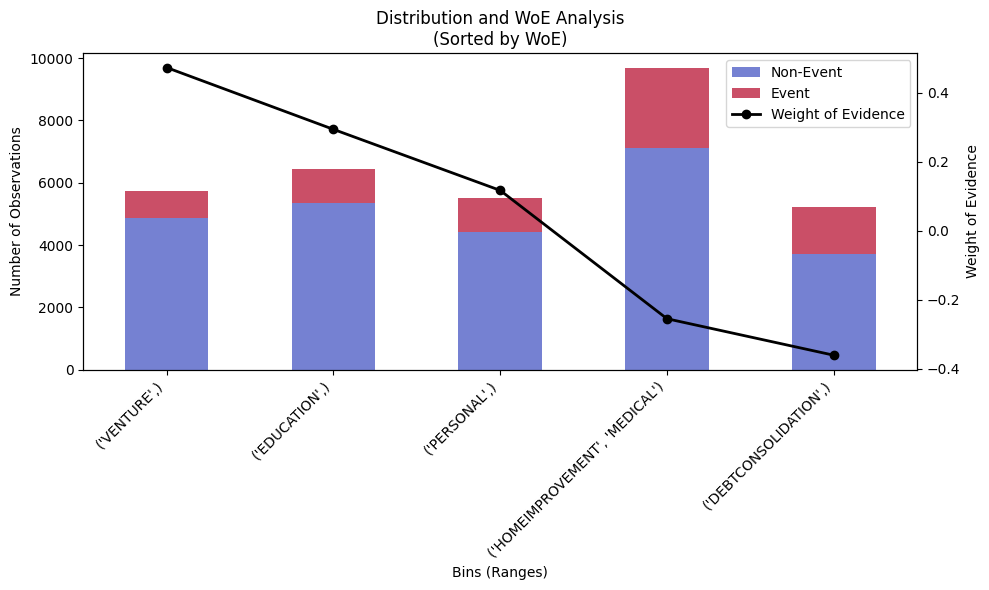

In [40]:
binner3.plot_binning()

In [41]:
import optbinning as optbinning

optb = optbinning.OptimalBinning(name="person_age", dtype="categorical", solver="cp")
optb.fit(df['loan_intent'], df['loan_status'])
optb._binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[VENTURE],5719,0.175532,4872,847,0.148103,0.473161,0.034115,0.004225
1,[EDUCATION],6453,0.198060,5342,1111,0.172168,0.293941,0.015699,0.001955
2,[PERSONAL],5521,0.169455,4423,1098,0.198877,0.11693,0.002240,0.000280
3,[HOMEIMPROVEMENT],3605,0.110647,2664,941,0.261026,-0.235757,0.006555,0.000818
4,[MEDICAL],6071,0.186336,4450,1621,0.267007,-0.266537,0.014222,0.001772
5,[DEBTCONSOLIDATION],5212,0.159971,3722,1490,0.285879,-0.360913,0.022921,0.002850
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,32581,1.000000,25473,7108,0.218164,,0.095752,0.011900


In [42]:
table = optb.binning_table.build()
print("The difference in IV is:", table.loc[table.index[-1], 'IV'] - binner3.get_binning_table()['IV'].sum().round(4))

# print percentage difference
print("The percentage difference in IV is:", ((table.loc[table.index[-1], 'IV'] - binner3.get_binning_table()['IV'].sum().round(4)) / table.loc[table.index[-1], 'IV']) * 100)

The difference in IV is: 5.234776986630385e-05
The percentage difference in IV is: 0.054669959625551795


#### Person employment length

In [67]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['person_emp_length']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.5485 ± 0.0138
Max leaf nodes:  3, ROC AUC: 0.5633 ± 0.0164
Max leaf nodes:  4, ROC AUC: 0.5642 ± 0.0165
Max leaf nodes:  5, ROC AUC: 0.5655 ± 0.0169
Max leaf nodes:  6, ROC AUC: 0.5674 ± 0.0173
Max leaf nodes:  7, ROC AUC: 0.5689 ± 0.0187
Max leaf nodes:  8, ROC AUC: 0.5683 ± 0.0189
Max leaf nodes:  9, ROC AUC: 0.5683 ± 0.0193
Max leaf nodes: 10, ROC AUC: 0.5683 ± 0.0193

Best max_leaf_nodes: 7 with ROC AUC: 0.5689


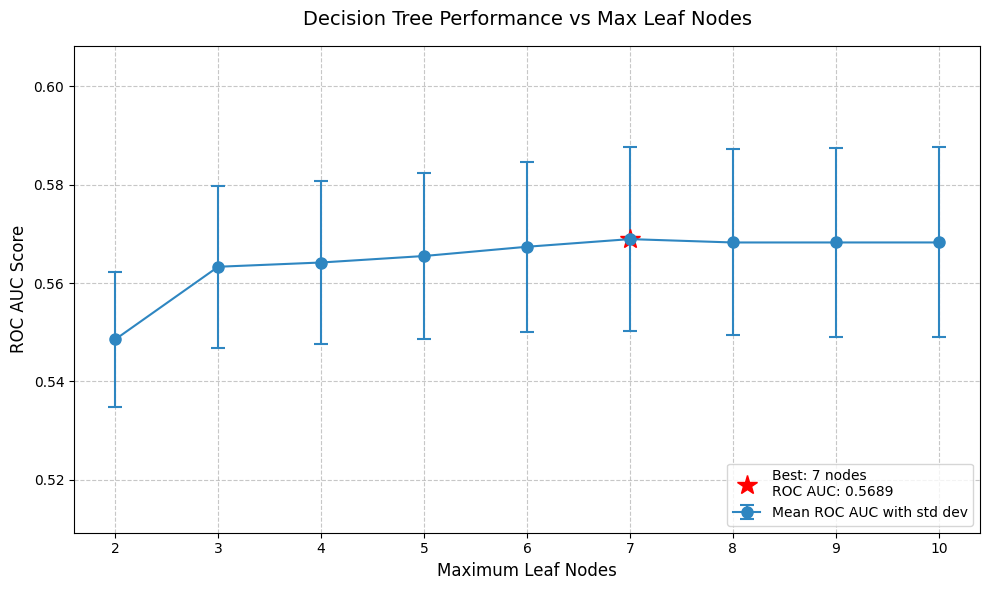

In [68]:
plot_tree_performance(all_results)

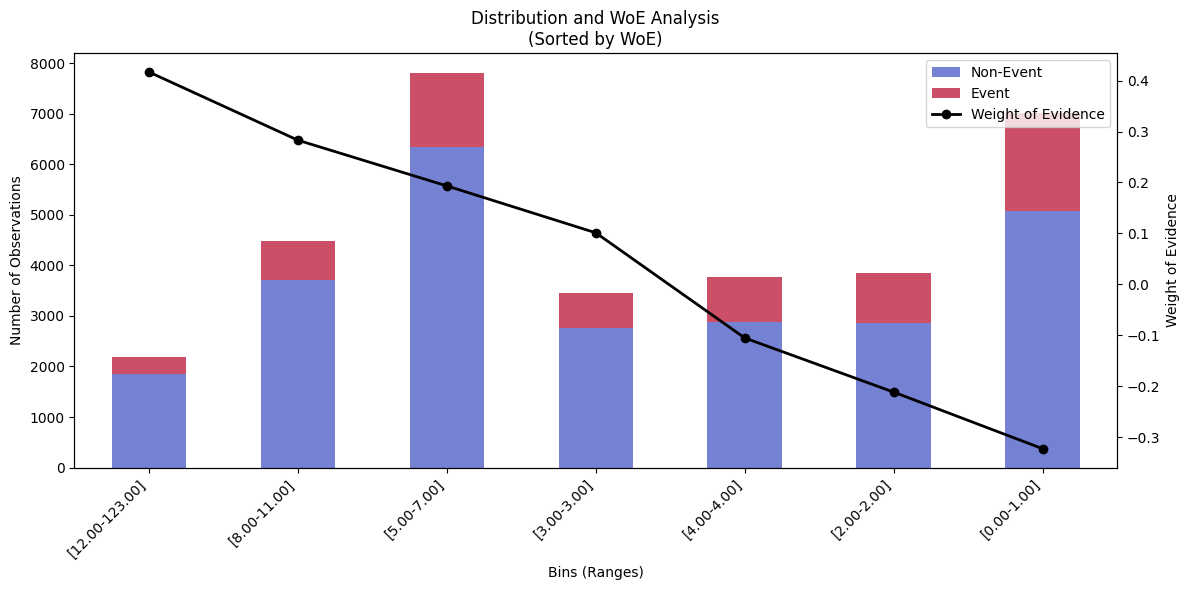

In [69]:
df, bin_stats, bin_labels = create_binned_feature(df, 'person_emp_length', 'loan_status', max_leaf_nodes=7)
df, woe_summary, iv = calculate_woe(df, 'person_emp_length', 'loan_status', plot=True, bin_labels=bin_labels)

In [70]:
woe_summary

,non_event_count,event_count,non_event_rate,event_rate,WoE,IV
person_emp_length_bin_label,,,,,,
[12.00-123.00],1849,340,0.0726,0.0478,0.4171,0.010323
[8.00-11.00],3710,780,0.1456,0.1097,0.2831,0.010166
[5.00-7.00],6348,1460,0.2492,0.2054,0.1933,0.008467
[3.00-3.00],2760,696,0.1084,0.0979,0.1012,0.001056
[4.00-4.00],2877,892,0.1129,0.1255,-0.1054,0.001322
[2.00-2.00],2862,987,0.1124,0.1389,-0.2118,0.005613
[0.00-1.00],5067,1953,0.1989,0.2748,-0.3230,0.024499


In [81]:
binner = OptimalBinning(min_bins=2, max_bins=10, min_samples_bin=0.05, monotonic_trend='descending', p_value_threshold=0.05)
binner.fit(df['person_emp_length'], df['loan_status'])
binner.get_binning_table()

,Bin,Count,Non-event,Event,Event rate,WoE,IV
0,"[-inf, 2)",7020,5067,1953,0.278205,-0.329035,0.014887
1,"[2, 3)",3849,2862,987,0.256430,-0.211792,0.005613
2,"[3, 5)",7225,5637,1588,0.219792,-0.009522,0.000020
3,"[5, 12)",12298,10058,2240,0.182143,0.193305,0.008467
4,"[12, inf)",2189,1849,340,0.155322,0.417056,0.010323


#### Loan amount

In [82]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['loan_amnt']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.5297 ± 0.0731
Max leaf nodes:  3, ROC AUC: 0.5243 ± 0.0888
Max leaf nodes:  4, ROC AUC: 0.5426 ± 0.0899
Max leaf nodes:  5, ROC AUC: 0.5346 ± 0.1070
Max leaf nodes:  6, ROC AUC: 0.5315 ± 0.1051
Max leaf nodes:  7, ROC AUC: 0.5197 ± 0.0938
Max leaf nodes:  8, ROC AUC: 0.5187 ± 0.0936
Max leaf nodes:  9, ROC AUC: 0.5244 ± 0.0982
Max leaf nodes: 10, ROC AUC: 0.5281 ± 0.0954

Best max_leaf_nodes: 4 with ROC AUC: 0.5426


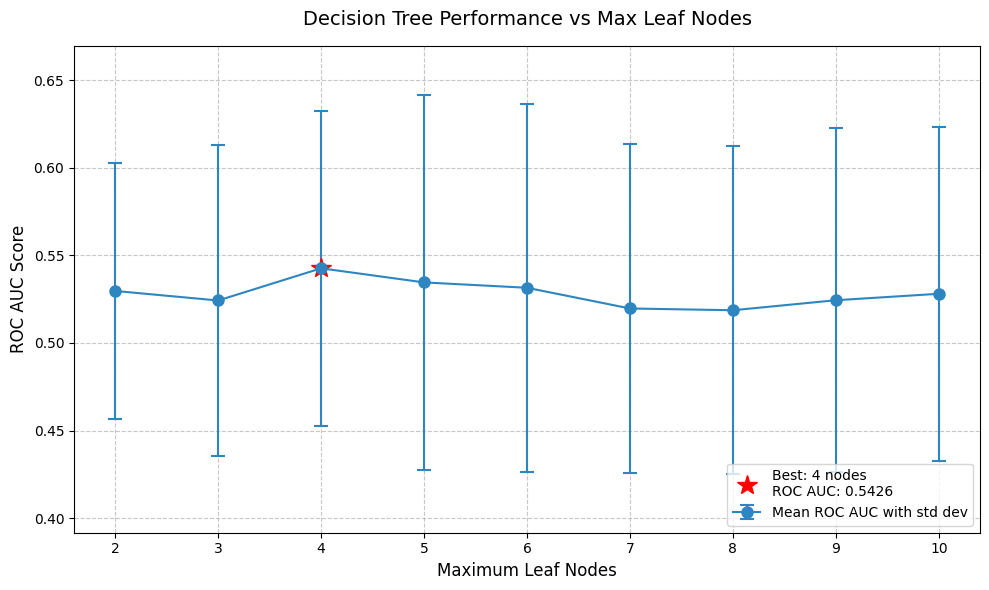

In [83]:
plot_tree_performance(all_results)

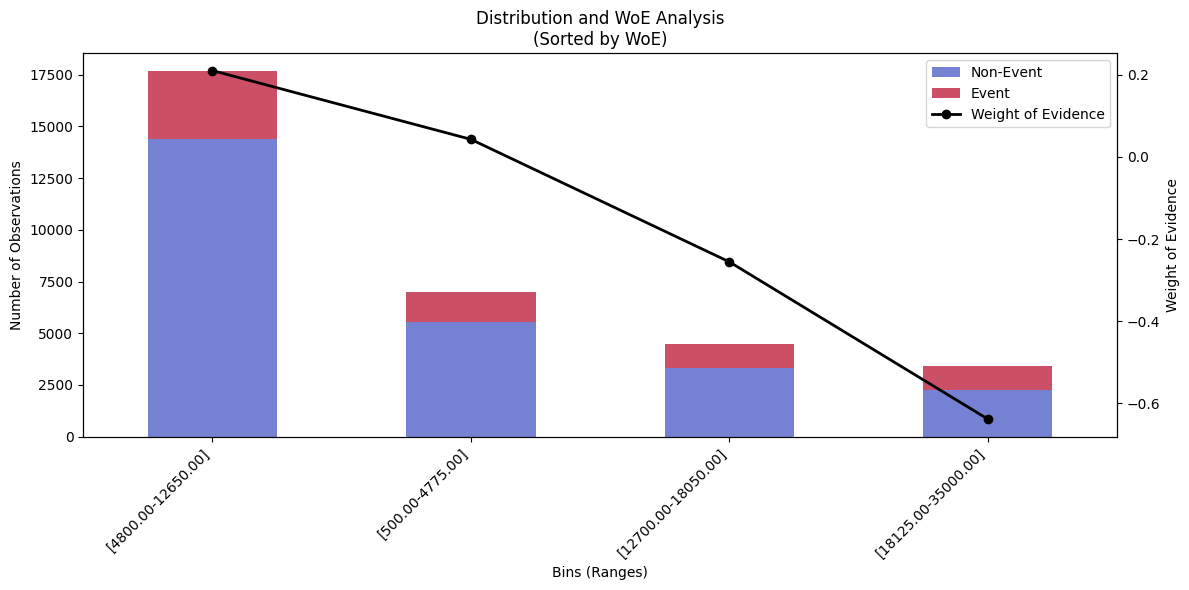

In [84]:
df, bin_stats, bin_labels = create_binned_feature(df, 'loan_amnt', 'loan_status', max_leaf_nodes=4)
df, woe_summary, iv = calculate_woe(df, 'loan_amnt', 'loan_status', plot=True, bin_labels=bin_labels)

In [85]:
woe_summary

,non_event_count,event_count,non_event_rate,event_rate,WoE,IV
loan_amnt_bin_label,,,,,,
[4800.00-12650.00],14409,3257,0.5657,0.4582,0.2106,0.022632
[500.00-4775.00],5518,1475,0.2166,0.2075,0.0430,0.000391
[12700.00-18050.00],3300,1189,0.1295,0.1673,-0.2556,0.009643
[18125.00-35000.00],2246,1187,0.0882,0.1670,-0.6387,0.050342


In [89]:
binner = OptimalBinning(min_bins=2, max_bins=10, min_samples_bin=0.05, monotonic_trend='ascending', p_value_threshold=0.05)
binner.fit(df['loan_amnt'], df['loan_status'])
binner.get_binning_table()

,Bin,Count,Non-event,Event,Event rate,WoE,IV
0,"[-inf, 10588)",21757,17618,4139,0.190238,0.188080,1.496429e-02
1,"[10588, 14488)",4251,3324,927,0.218066,0.000572,4.274703e-08
2,"[14488, 18088)",3140,2285,855,0.272293,-0.293378,8.972735e-03
3,"[18088, 22150)",1658,1120,538,0.324487,-0.543173,1.723011e-02
4,"[22150, inf)",1775,1126,649,0.365634,-0.725404,3.416791e-02


#### Loan interest rate

In [51]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['loan_int_rate']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.6450 ± 0.0100
Max leaf nodes:  3, ROC AUC: 0.6901 ± 0.0103
Max leaf nodes:  4, ROC AUC: 0.6932 ± 0.0103
Max leaf nodes:  5, ROC AUC: 0.7009 ± 0.0114
Max leaf nodes:  6, ROC AUC: 0.7032 ± 0.0110
Max leaf nodes:  7, ROC AUC: 0.7053 ± 0.0112
Max leaf nodes:  8, ROC AUC: 0.7070 ± 0.0124
Max leaf nodes:  9, ROC AUC: 0.7078 ± 0.0124
Max leaf nodes: 10, ROC AUC: 0.7080 ± 0.0127

Best max_leaf_nodes: 10 with ROC AUC: 0.7080


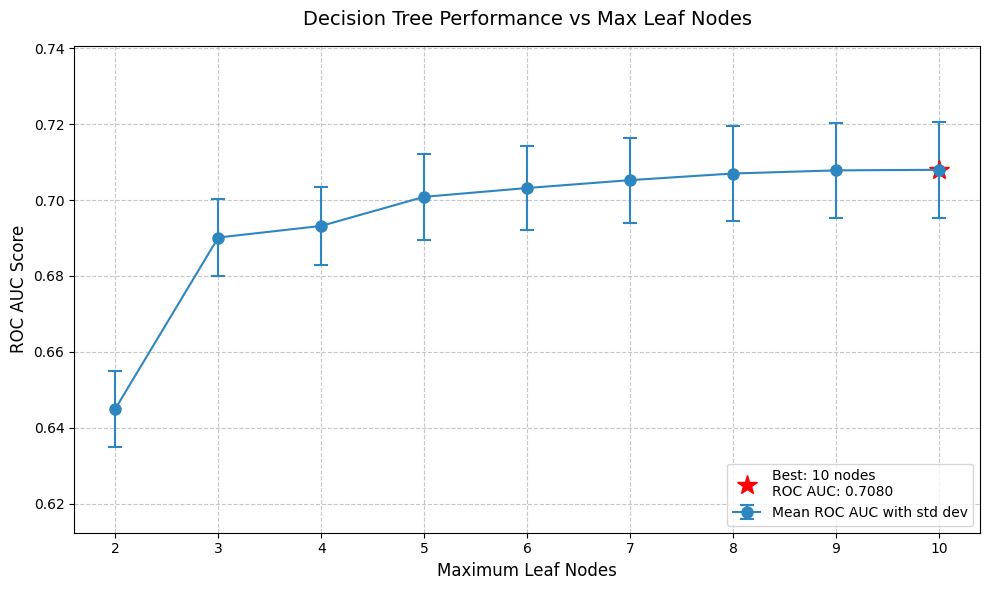

In [52]:
plot_tree_performance(all_results)

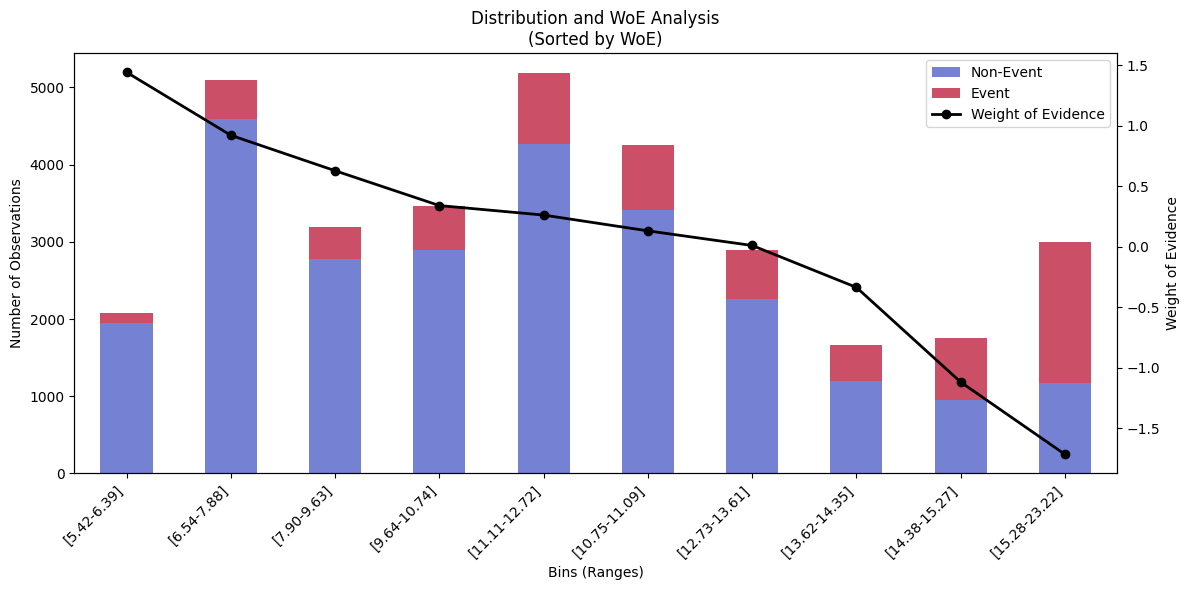

In [53]:
df, bin_stats, bin_labels = create_binned_feature(df, 'loan_int_rate', 'loan_status', max_leaf_nodes=10)
df, woe_summary, iv = calculate_woe(df, 'loan_int_rate', 'loan_status', plot=True, bin_labels=bin_labels)

#### Loan percent income

In [55]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['loan_percent_income']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.6673 ± 0.0261
Max leaf nodes:  3, ROC AUC: 0.7087 ± 0.0296
Max leaf nodes:  4, ROC AUC: 0.7131 ± 0.0294
Max leaf nodes:  5, ROC AUC: 0.7160 ± 0.0282
Max leaf nodes:  6, ROC AUC: 0.7167 ± 0.0296
Max leaf nodes:  7, ROC AUC: 0.7163 ± 0.0290
Max leaf nodes:  8, ROC AUC: 0.7160 ± 0.0287
Max leaf nodes:  9, ROC AUC: 0.7163 ± 0.0284
Max leaf nodes: 10, ROC AUC: 0.7163 ± 0.0283

Best max_leaf_nodes: 6 with ROC AUC: 0.7167


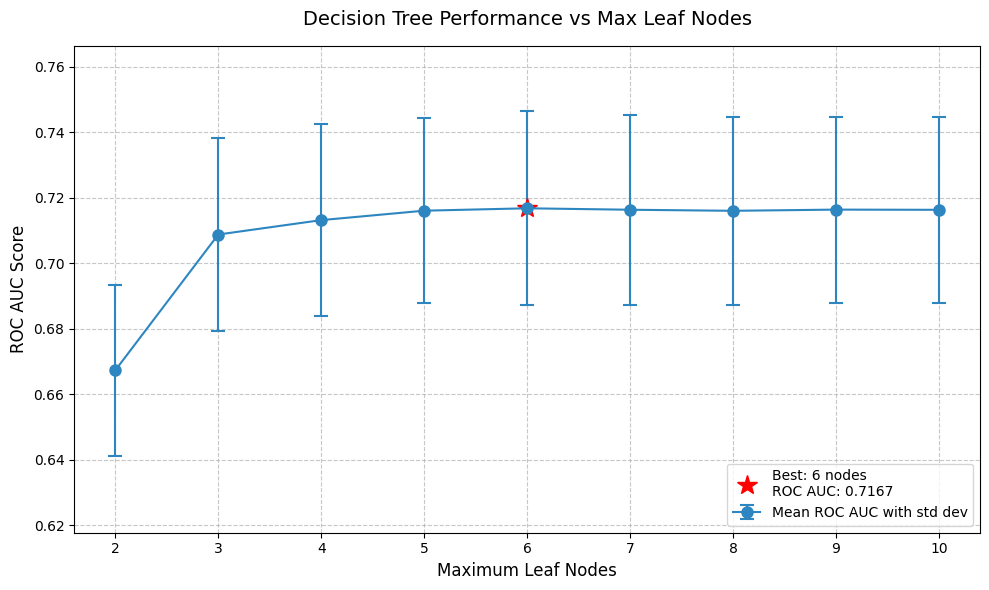

In [56]:
plot_tree_performance(all_results)

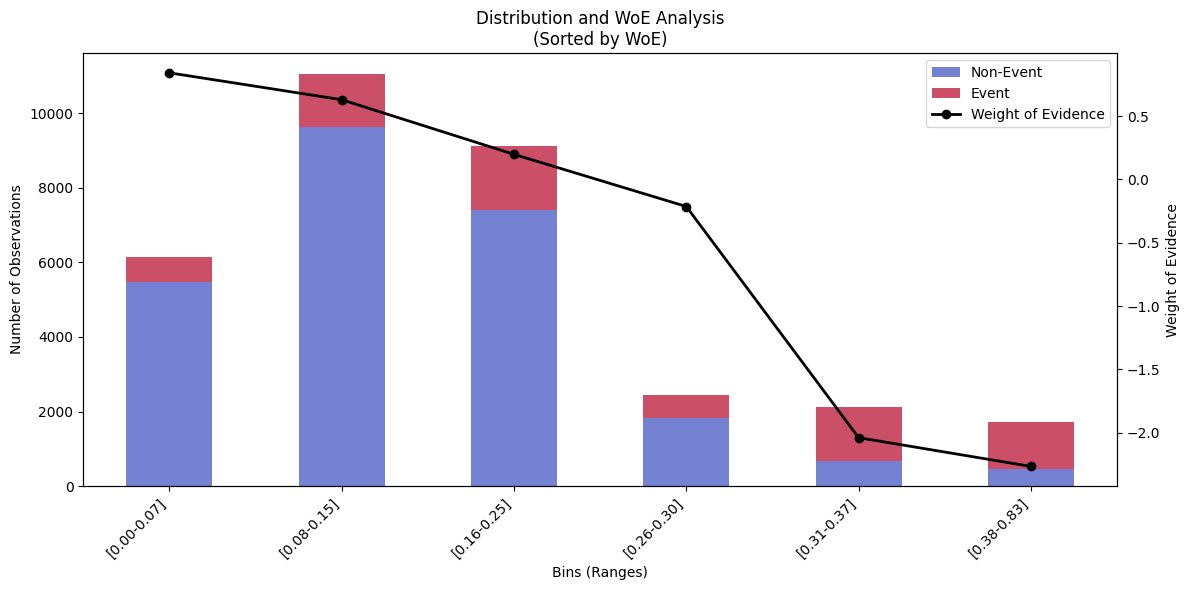

In [57]:
df, bin_stats, bin_labels = create_binned_feature(df, 'loan_percent_income', 'loan_status', max_leaf_nodes=6)
df, woe_summary, iv = calculate_woe(df, 'loan_percent_income', 'loan_status', plot=True, bin_labels=bin_labels)

#### cb_person_cred_hist_length

In [59]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['cb_person_cred_hist_length']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.5000 ± 0.0000
Max leaf nodes:  3, ROC AUC: 0.5094 ± 0.0147
Max leaf nodes:  4, ROC AUC: 0.4982 ± 0.0060
Max leaf nodes:  5, ROC AUC: 0.4937 ± 0.0113
Max leaf nodes:  6, ROC AUC: 0.4924 ± 0.0114
Max leaf nodes:  7, ROC AUC: 0.4923 ± 0.0115
Max leaf nodes:  8, ROC AUC: 0.4923 ± 0.0115
Max leaf nodes:  9, ROC AUC: 0.4921 ± 0.0112
Max leaf nodes: 10, ROC AUC: 0.4922 ± 0.0113

Best max_leaf_nodes: 3 with ROC AUC: 0.5094


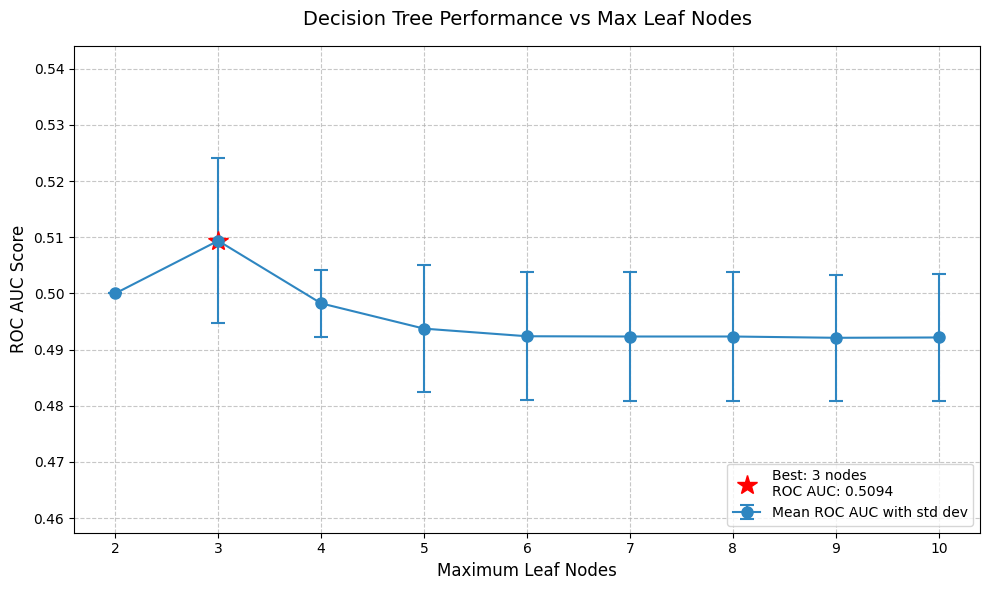

In [60]:
plot_tree_performance(all_results)

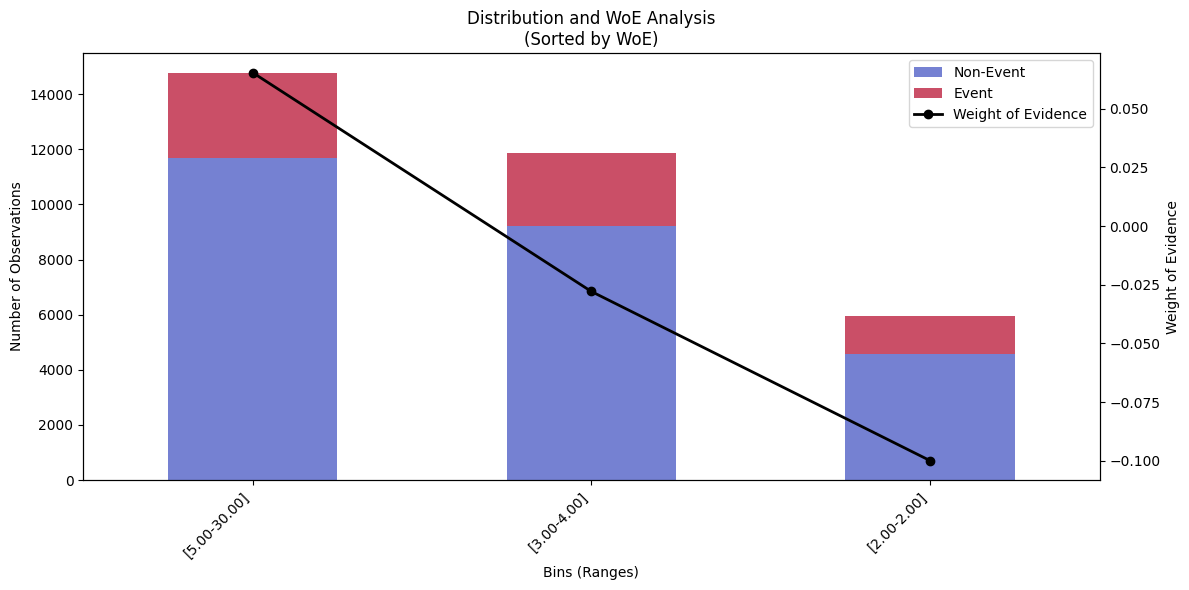

In [61]:
df, bin_stats, bin_labels = create_binned_feature(df, 'cb_person_cred_hist_length', 'loan_status', max_leaf_nodes=3)
df, woe_summary, iv = calculate_woe(df, 'cb_person_cred_hist_length', 'loan_status', plot=True, bin_labels=bin_labels)

In [66]:
cat_columns = df.select_dtypes(include=['object']).columns

def calculate_woe(col, df):
    crosstab_woe = pd.crosstab(df[col], df["loan_status"], normalize='columns')
    df[col + "_woe"] = df[col].map(np.log(crosstab_woe[0] / crosstab_woe[1]))

    return df

for col in cat_columns:
    df = calculate_woe(col, df)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_age                         32581 non-null  int64  
 1   person_income                      32581 non-null  int64  
 2   person_home_ownership              32581 non-null  object 
 3   person_emp_length                  32581 non-null  float64
 4   loan_intent                        32581 non-null  object 
 5   loan_grade                         32581 non-null  object 
 6   loan_amnt                          32581 non-null  int64  
 7   loan_int_rate                      32581 non-null  float64
 8   loan_status                        32581 non-null  int64  
 9   loan_percent_income                32581 non-null  float64
 10  cb_person_default_on_file          32581 non-null  object 
 11  cb_person_cred_hist_length         32581 non-null  int

#### Optimal binning

In [10]:
optbinner = OptimalBinning(name="loan_int_rate", dtype="numerical")

optbinner.fit(df['loan_int_rate'], df['loan_status'])

df['binned'] = optbinner.transform(df['loan_int_rate'], metric="bins")

bin_mapping = {bin_: f'Bin {i}' for i, bin_ in enumerate(natsorted(df['binned'].unique()))}
df['bin'] = df['binned'].map(bin_mapping)

df.groupby(['binned', 'bin'])['loan_int_rate'].agg(['min', 'max', 'mean', 'count']).sort_values(by='mean')

,,min,max,mean,count
binned,bin,,,,
"(-inf, 6.46)",Bin 0,5.42,6.39,5.828858,2084
"[6.46, 7.46)",Bin 1,6.54,7.43,6.942228,2531
"[7.46, 7.89)",Bin 2,7.49,7.88,7.634286,2569
"[7.89, 9.64)",Bin 3,7.90,9.63,8.730301,3186
"[9.64, 10.76)",Bin 4,9.64,10.75,10.300236,3645
"[10.76, 12.07)",Bin 5,10.78,12.04,11.248694,7426
"[12.07, 12.72)",Bin 6,12.09,12.72,12.461382,1831
"[12.72, 13.61)",Bin 7,12.73,13.61,13.216610,2891
"[13.61, 14.37)",Bin 8,13.62,14.35,14.052413,1662


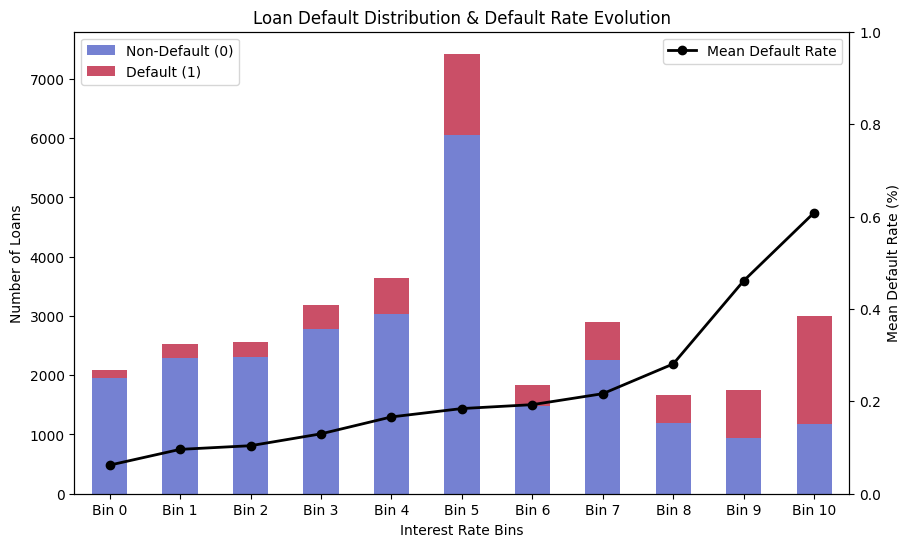

In [11]:
# Group by bins to count defaults vs. non-defaults
bin_counts = df.groupby(['bin', 'loan_status']).size().unstack(fill_value=0)

# Calculate mean default rate per bin
bin_default_rate = df.groupby('bin')['loan_status'].mean()

# Sort by bin order
bin_counts = bin_counts.loc[natsorted(bin_counts.index)]
bin_default_rate = bin_default_rate.loc[natsorted(bin_default_rate.index)]

# 🔹 PLOTTING 🔹
fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar plot for default & non-default counts
bin_counts.plot(kind='bar', stacked=True, ax=ax1, colormap="coolwarm", alpha=0.7)
ax1.set_xlabel("Interest Rate Bins")
ax1.set_ylabel("Number of Loans")
ax1.set_title("Loan Default Distribution & Default Rate Evolution")

# Create a second y-axis for default rate
ax2 = ax1.twinx()
ax2.plot(bin_default_rate.index, bin_default_rate.values, marker='o', color='black', linestyle='-', linewidth=2, label="Mean Default Rate")

ax2.set_ylabel("Mean Default Rate (%)")
ax2.set_ylim(0, 1)  # Default rate is between 0 and 1

# Show legend
ax1.legend(["Non-Default (0)", "Default (1)"], loc="upper left")
ax2.legend(loc="upper right")

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
plt.show()

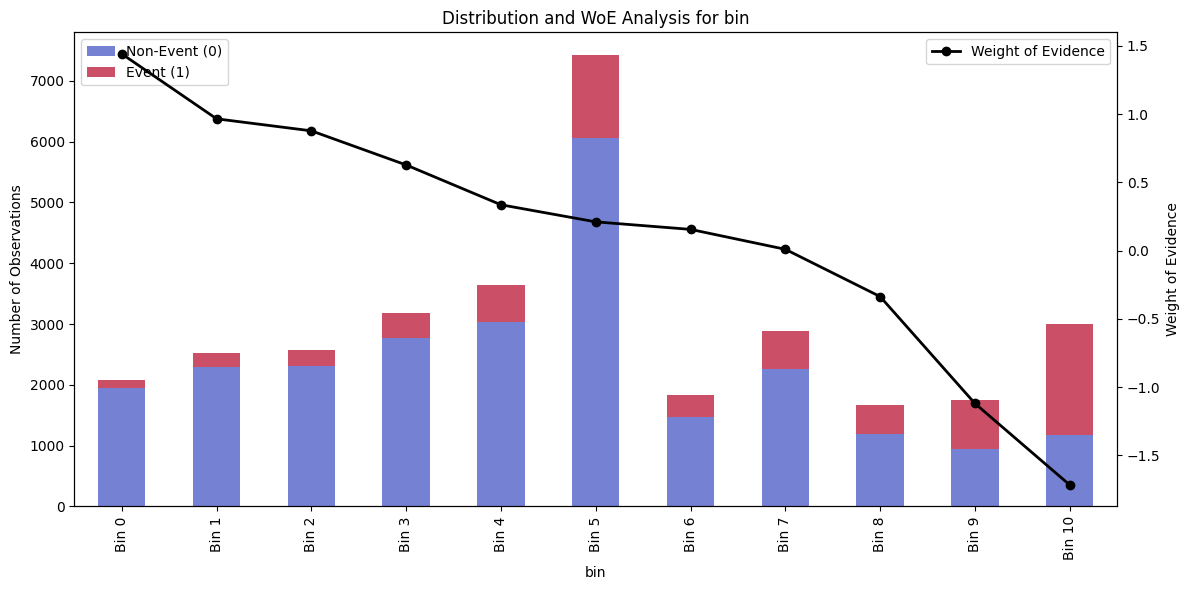

In [12]:
woe_summary, iv = metrics.calculate_woe(df, 'bin', 'loan_status', plot=True)